CS 719 - Data Science Project

Harpreet Singh



## Weather Forecasting with Time Series and Neural Networks

1. Univeriate Time Series Forecasting
2. Multivariate Time Series Forecasting
3. Spatio-Temporal Forecasting

Forecast will be performed on mainly two weather patterns i.e. Average Temperature, Average Wind Speed. 



Importing all the required liberaries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import pmdarima as pm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults
import matplotlib as m
import seaborn as sns

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:00


### Preprocessing of Temporal Data

Reading the dataset
<br> <br> As a part for First Temporal Approach, we are using temporal data of our target station, that is Torronto city.

In [3]:
df = pd.read_excel("/content/Torronto Daily.xlsx")

In [4]:
df.head()

station        day max_temp_f min_temp_f precip_in avg_wind_speed_kts  \
0    CYTZ 2017-01-01       37.4         32      None          11.956522   
1    CYTZ 2017-01-02         41         32      None           11.34296   
2    CYTZ 2017-01-03         41       39.2      None            8.44124   
3    CYTZ 2017-01-04       39.2       19.4      None          20.355797   
4    CYTZ 2017-01-05         23       15.8      None          18.696377   

  avg_wind_drct max_wind_speed_kts max_wind_gust_kts  
0     245.61368                 21                28  
1      64.91508                 17                21  
2     57.301846                 12              None  
3     257.71188                 33                42  
4      254.1532                 28                36

Checking for Null Values. <br> In dataset, null values are represented with string "None", thus creating custom function to check for null values

In [5]:
def checkforNulls(df):
  for i in df.columns:
    print("\n Column : {}".format(i))
    count = 0
    for j in df[i]:
      if j == "None":
        count = count+1
    print("Null count : ",count)

In [6]:
checkforNulls(df)


 Column : station
Null count :  0

 Column : day
Null count :  0

 Column : max_temp_f
Null count :  2

 Column : min_temp_f
Null count :  2

 Column : precip_in
Null count :  2210

 Column : avg_wind_speed_kts
Null count :  1

 Column : avg_wind_drct
Null count :  1

 Column : max_wind_speed_kts
Null count :  1

 Column : max_wind_gust_kts
Null count :  408


These 2 (max_wind_gust_kts, precip_in) columns have large amount of null values, thus will drop these columns

In [7]:
df.drop(['max_wind_gust_kts','precip_in'],axis=1, inplace=True)

In [8]:
checkforNulls(df)


 Column : station
Null count :  0

 Column : day
Null count :  0

 Column : max_temp_f
Null count :  2

 Column : min_temp_f
Null count :  2

 Column : avg_wind_speed_kts
Null count :  1

 Column : avg_wind_drct
Null count :  1

 Column : max_wind_speed_kts
Null count :  1


Using the forward fill method for imputation of null values

In [9]:
df = df.replace('None', np.nan)

In [10]:
df.ffill(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   station             2212 non-null   object        
 1   day                 2212 non-null   datetime64[ns]
 2   max_temp_f          2212 non-null   float64       
 3   min_temp_f          2212 non-null   float64       
 4   avg_wind_speed_kts  2212 non-null   float64       
 5   avg_wind_drct       2212 non-null   float64       
 6   max_wind_speed_kts  2212 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 121.1+ KB


In [12]:
wTor = df.copy() #Creating dataset copy
wTor.set_index("day",inplace=True)  #setting column day as index

In [13]:
wTor.drop("station", axis=1, inplace=True)  #dropping the station name as its just one station

In [14]:
wTor.head()

max_temp_f  min_temp_f  avg_wind_speed_kts  avg_wind_drct  \
day                                                                     
2017-01-01        37.4        32.0           11.956522     245.613680   
2017-01-02        41.0        32.0           11.342960      64.915080   
2017-01-03        41.0        39.2            8.441240      57.301846   
2017-01-04        39.2        19.4           20.355797     257.711880   
2017-01-05        23.0        15.8           18.696377     254.153200   

            max_wind_speed_kts  
day                             
2017-01-01                21.0  
2017-01-02                17.0  
2017-01-03                12.0  
2017-01-04                33.0  
2017-01-05                28.0

In [15]:
wTor.columns = ["MaxT","MinT","AvgWind","WindDir","MaxWind"]   # Renaming the columns

Creating average daily temperature column

In [16]:
def avg_temp(day):
    return (day.MaxT+day.MinT)/2
wTor['AvgT'] = wTor.apply(avg_temp,axis=1)


In [17]:
wTor.loc[wTor.AvgT <= 0]["AvgT"]

day
2018-01-05   -0.4
2018-01-06   -1.3
Name: AvgT, dtype: float64

We just have two rows where we have negative values, thus we will set those to 0 to avoid inconsistancies. 

In [18]:
wTor.loc[wTor.AvgT <= 0]["AvgT"] = 0

<ipython-input-18-2be9159edd37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wTor.loc[wTor.AvgT <= 0]["AvgT"] = 0


Getting description of the dataset

In [19]:
wTor.describe() 

MaxT         MinT      AvgWind      WindDir      MaxWind  \
count  2212.000000  2212.000000  2212.000000  2212.000000  2212.000000   
mean     54.565913    43.326492     9.402608   192.024625    16.782098   
std      18.182012    17.143949     4.086955    98.971972     6.182911   
min       5.000000    -7.600000     1.866667     2.021540     5.000000   
25%      39.200000    32.000000     6.378805    77.883904    12.000000   
50%      53.600000    42.800000     8.521739   222.487950    16.000000   
75%      71.600000    59.000000    11.640399   273.772427    20.000000   
max      95.000000    77.000000    32.034100   359.808380    44.000000   

              AvgT  
count  2212.000000  
mean     48.946203  
std      17.484380  
min      -1.300000  
25%      35.600000  
50%      47.300000  
75%      65.300000  
max      85.100000

In [20]:
wTor.sort_values(by="AvgWind",ascending=False)

MaxT  MinT    AvgWind     WindDir  MaxWind  AvgT
day                                                         
2018-04-15  33.8  26.6  32.034100   64.988990     41.0  30.2
2022-12-24  17.6   8.6  27.904348  244.861430     36.0  13.1
2019-02-12  35.6  23.0  26.939290   74.219345     37.0  29.3
2019-12-01  33.8  30.2  26.405160   65.503500     36.0  32.0
2022-03-23  39.2  35.6  25.925686   65.921890     35.0  37.4
...          ...   ...        ...         ...      ...   ...
2019-06-28  77.0  64.4   2.646282  239.516660     15.0  70.7
2018-06-09  71.6  57.2   2.608696  222.531900      6.0  64.4
2021-06-08  75.2  62.6   2.480315  217.447720      6.0  68.9
2019-09-17  69.8  55.4   2.478261  144.767490      6.0  62.6
2020-11-08  64.4  44.6   1.866667  219.673780      6.0  54.5

[2212 rows x 6 columns]

As a part of Data analysis, we will create 2 more attributes to specify winter and summer months, so that we can analyze the data with more detail and impacts of weather patterns in different seasons. 


Winter ~ Oct-Apr

Summer ~ May-Sept

In [21]:
wTor_season = wTor.copy(deep=True)
wTor_season['month'] = wTor_season.index.month

tCal = (wTor_season['month'] >= 5) & (wTor_season['month'] <= 9)
wTor_season['summer'] = np.where(tCal,1,0)
wTor_season['winter'] = np.where(wTor_season['summer'] != 1,1,0)
wTor_season

MaxT  MinT    AvgWind     WindDir  MaxWind  AvgT  month  summer  \
day                                                                           
2017-01-01  37.4  32.0  11.956522  245.613680     21.0  34.7      1       0   
2017-01-02  41.0  32.0  11.342960   64.915080     17.0  36.5      1       0   
2017-01-03  41.0  39.2   8.441240   57.301846     12.0  40.1      1       0   
2017-01-04  39.2  19.4  20.355797  257.711880     33.0  29.3      1       0   
2017-01-05  23.0  15.8  18.696377  254.153200     28.0  19.4      1       0   
...          ...   ...        ...         ...      ...   ...    ...     ...   
2023-01-17  39.2  33.8  10.680435   56.813300     20.0  36.5      1       0   
2023-01-18  42.8  37.4  10.594360  284.708860     17.0  40.1      1       0   
2023-01-19  39.2  35.6  20.628057   64.660164     30.0  37.4      1       0   
2023-01-20  39.2  32.0   9.893478  317.770900     19.0  35.6      1       0   
2023-01-21  33.8  30.2   8.504348  293.190100     13.0  32.0      1       0   

            winter  
day                 
2017-01-01       1  
2017-01-02       1  
2017-01-03       1  
2017-01-04       1  
2017-01-05       1  
...            ...  
2023-01-17       1  
2023-01-18       1  
2023-01-19       1  
2023-01-20       1  
2023-01-21       1  

[2212 rows x 9 columns]

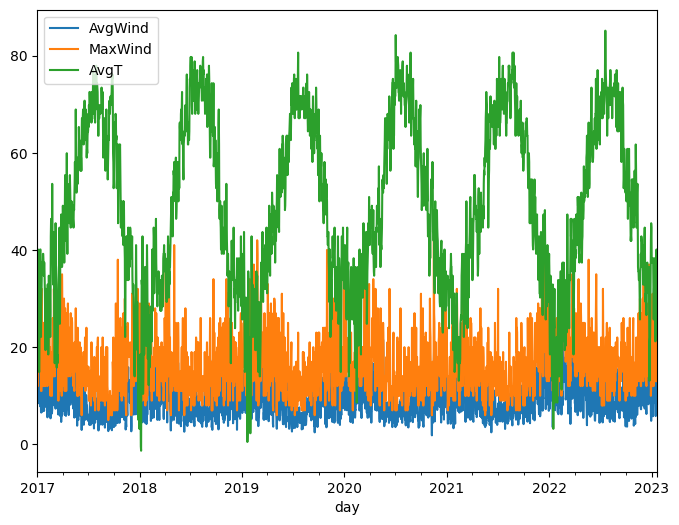

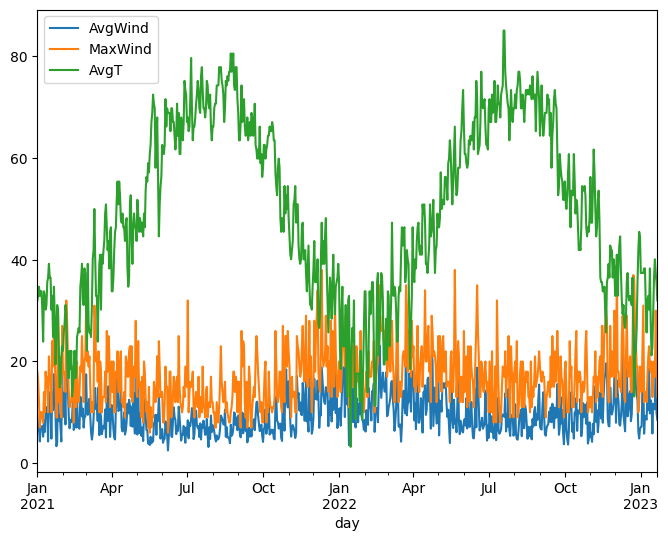

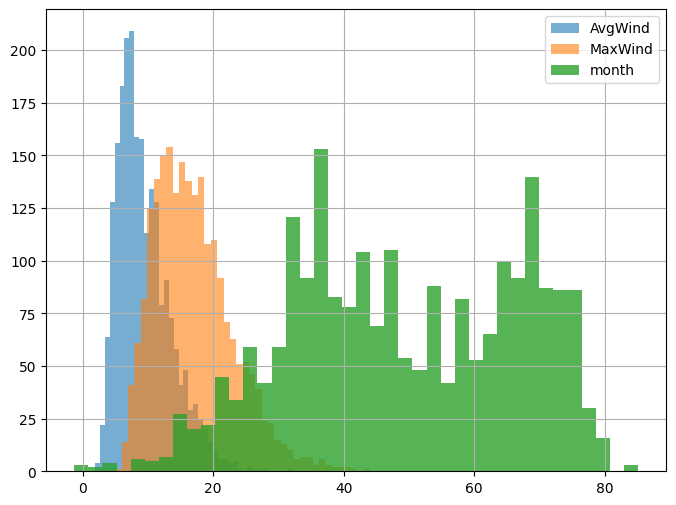

In [22]:
# timeseries plot - all data
wTor_season[["AvgWind", "MaxWind", "AvgT"]].plot(figsize=(8,6))
plt.show()
wTor_season.loc["2021-01-01":,["AvgWind", "MaxWind", "AvgT"]].plot(figsize=(8,6))

plt.figure(figsize=(8,6))
wTor_season.AvgWind.hist(bins=40, alpha=0.6, label='AvgWind')
wTor_season.MaxWind.hist(bins=40, alpha=0.6, label='MaxWind')
wTor_season.AvgT.hist(bins=40, alpha=0.8, label='month')
plt.legend()
plt.show()

### Plotting for Correlation in Attributes

Plotting heatmap to check for correlations

<Axes: >

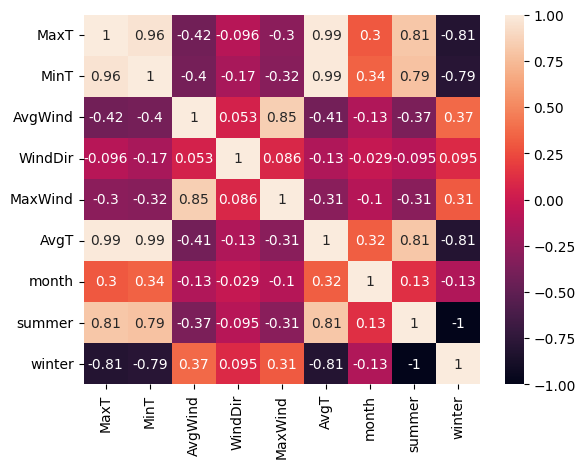

In [23]:
sns.heatmap(wTor_season.corr(), annot=True)

Creating a plot to see correlation between Avg Wind and Avg Temp


<Axes: xlabel='AvgWind', ylabel='AvgT'>

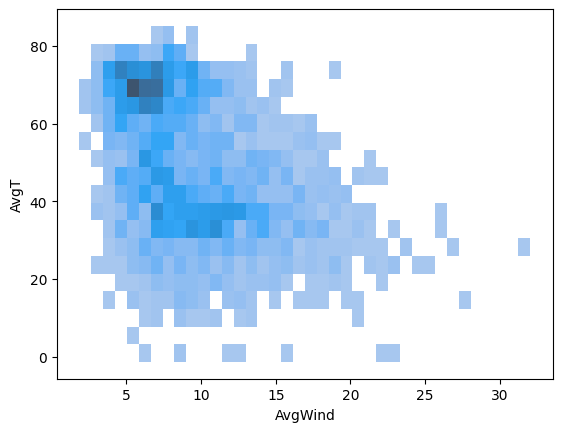

In [24]:
sns.histplot(data=wTor_season, x="AvgWind",y="AvgT")

Creating a plot to see correlation between Avg Temp and Month


<Axes: xlabel='month', ylabel='AvgT'>

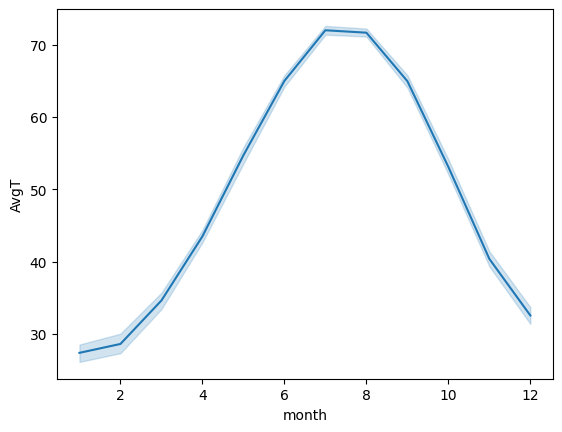

In [25]:
sns.lineplot(data=wTor_season[:], y="AvgT", x="month")

Creating a plot to see correlation between Avg Wind and Month

<Axes: xlabel='month', ylabel='AvgWind'>

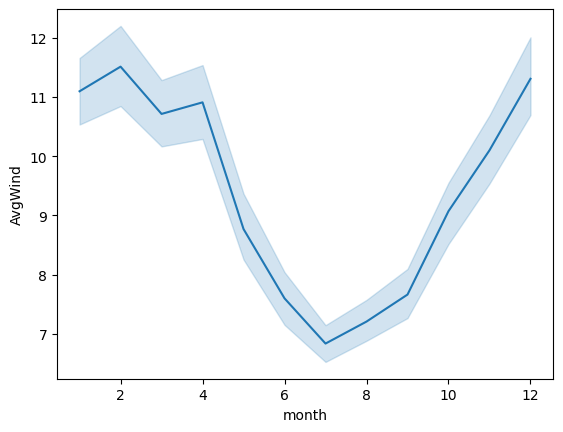

In [26]:
sns.lineplot(data=wTor_season[:], y="AvgWind", x="month")

Creating a plot to see correlation between Wind Direction and Month


<Axes: xlabel='month', ylabel='WindDir'>

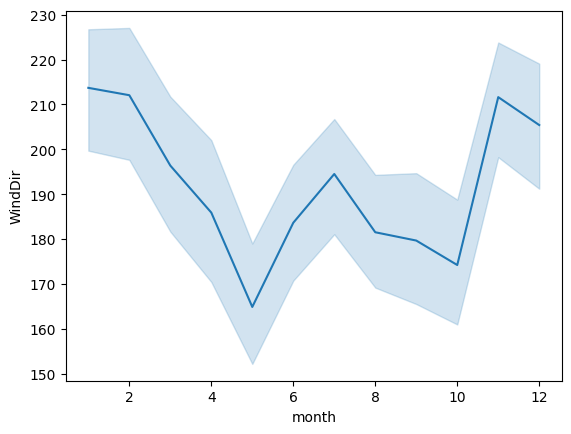

In [27]:
sns.lineplot(data=wTor_season[:], y="WindDir", x="month")

Creating a plot of Average wind with resepect to different seasons

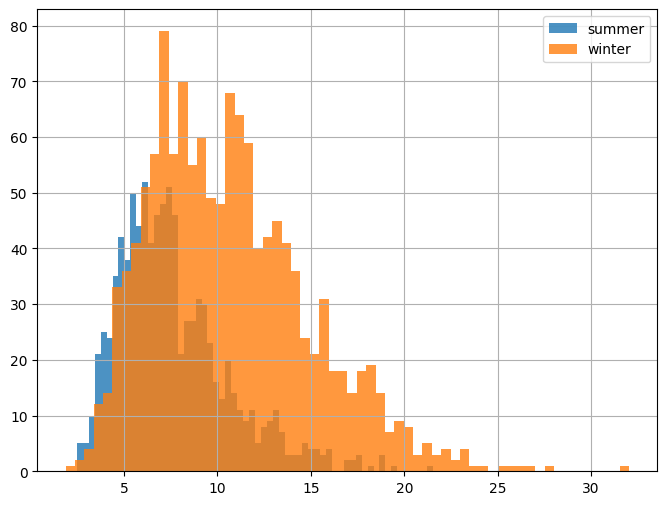

In [28]:
plt.figure(figsize=(8,6))
wTor_season[wTor_season['summer'] == 1]['AvgWind'].hist(bins=60, alpha=0.8, label='summer')
wTor_season[wTor_season['winter'] == 1]['AvgWind'].hist(bins=60, alpha=0.8, label='winter')
plt.legend()
plt.show()

Plotting temperature attribute based on the seasons

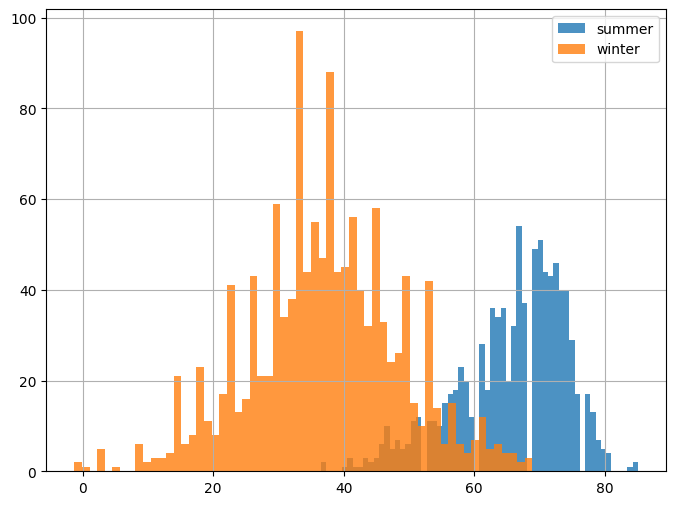

In [29]:
plt.figure(figsize=(8,6))
wTor_season[wTor_season['summer'] == 1]['AvgT'].hist(bins=60, alpha=0.8, label='summer')
wTor_season[wTor_season['winter'] == 1]['AvgT'].hist(bins=60, alpha=0.8, label='winter')
plt.legend()
plt.show()

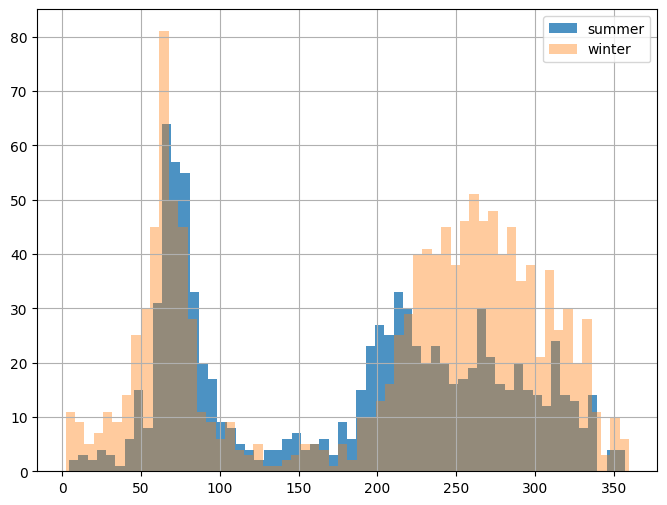

In [30]:
plt.figure(figsize=(8,6))
wTor_season[wTor_season['summer'] == 1]['WindDir'].hist(bins=60, alpha=0.8, label='summer')
wTor_season[wTor_season['winter'] == 1]['WindDir'].hist(bins=60, alpha=0.4, label='winter')
plt.legend()
plt.show()

Creating function for model evaluation



In [31]:
def model_performance(test, predictions): 
    mse = (((predictions) - (test)) ** 2).mean()
    mape = np.mean(np.abs((test) - (predictions)) / (test)) * 100
    normalizedrmse = np.sqrt(mse)/(test.max() - test.min())
    print(#'MSE : {}'.format(round(mse, 2))+
                  '\nRMSE : {}'.format(round(np.sqrt(mse), 2))+
                  '\nNormalized RMSE : {}'.format(round(normalizedrmse,2)))

### Decomposition of Series

Creating a function for series decomposition

In [32]:
def decompose_series(s):
    dcompseries = seasonal_decompose(s, period = 365,)
    dcompseries.plot()
    plt.show()

Decomposing Series of Average Wind into Trend, Seasonality, and Residuals

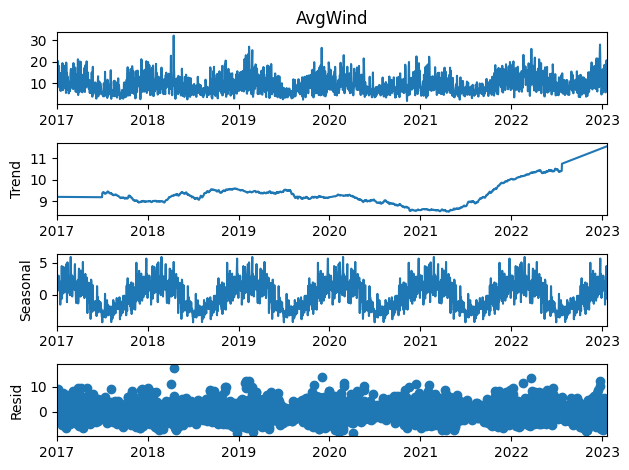

In [33]:
series_decomp = seasonal_decompose(wTor_season['AvgWind'], model='additive', period=int(365), extrapolate_trend='freq')
#Assigning decomposed variables
trend = series_decomp.trend
seasonal = series_decomp.seasonal
residual = series_decomp.resid
series_decomp.plot()
plt.show()

Decomposing Series of Average Temp into Trend, Seasonality, and Residuals

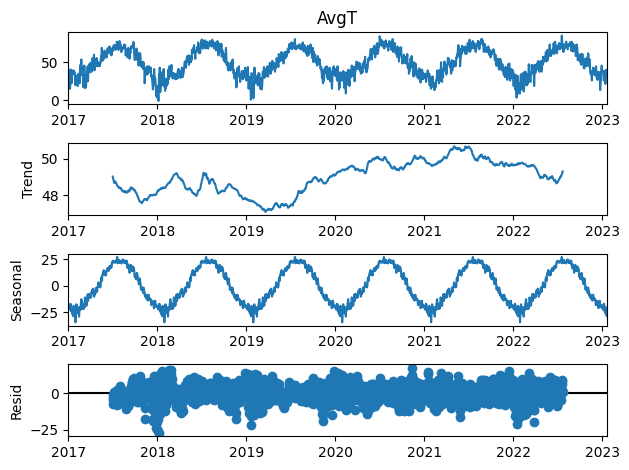

In [34]:
decompose_series(wTor_season["AvgT"])

### Checking for Stationarity - Dickey Fuller Test

Checking for DickeyFuller Test to check the stationarity in the Average Wind

In [35]:
adfVal = adfuller(wTor_season['AvgWind'], autolag = 'AIC')
print("1. ADF : ",adfVal[0])
print("2. P-Value : ", adfVal[1])
print("3. Num Of Lags : ", adfVal[2])
print("4. Num Of Observations", adfVal[3])
print("5. Critical Values :")
for key, val in adfVal[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.8860715870330726
2. P-Value :  0.0021397776318647873
3. Num Of Lags :  25
4. Num Of Observations 2186
5. Critical Values :
	 1% :  -3.433344965914077
	 5% :  -2.8628630765096195
	 10% :  -2.567474338973205


Value of p is less than 0.05 and ADF stat value is less than 5% CI rate, Thus series is stationary


-------------
Checking for DickeyFuller Test to check the stationarity in the Average Temp

In [36]:
adfVal = adfuller(wTor_season['AvgT'], autolag = 'AIC')
print("1. ADF : ",adfVal[0])
print("2. P-Value : ", adfVal[1])
print("3. Num Of Lags : ", adfVal[2])
print("4. Num Of Observations", adfVal[3])
print("5. Critical Values :")
for key, val in adfVal[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.668059468518559
2. P-Value :  0.07973032377199007
3. Num Of Lags :  12
4. Num Of Observations 2199
5. Critical Values :
	 1% :  -3.433327239607306
	 5% :  -2.8628552495229194
	 10% :  -2.5674701716229276


In [37]:
adfVal = adfuller(wTor_season['MinT'], autolag = 'AIC')
print("1. ADF : ",adfVal[0])
print("2. P-Value : ", adfVal[1])
print("3. Num Of Lags : ", adfVal[2])
print("4. Num Of Observations", adfVal[3])
print("5. Critical Values :")
for key, val in adfVal[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.537576611124574
2. P-Value :  0.10659711764514024
3. Num Of Lags :  20
4. Num Of Observations 2191
5. Critical Values :
	 1% :  -3.433338123180619
	 5% :  -2.862860055130884
	 10% :  -2.567472730288902


### Plotting ACF and PACF Plots

Checking for Auto Correlation Graph for Average Temp

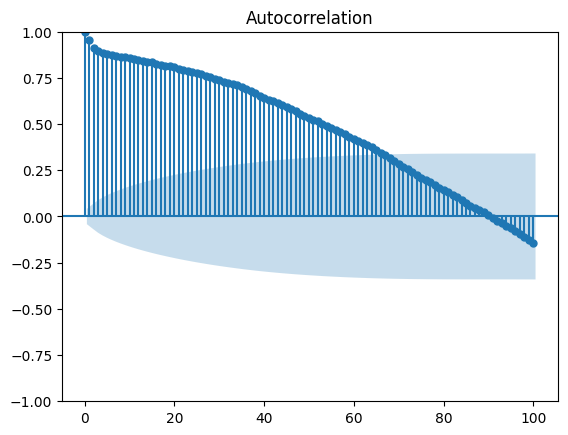

In [38]:
plot_acf(wTor_season['AvgT'], lags=100)
plt.show()

Checking for Auto Correlation Graph for Average Wind

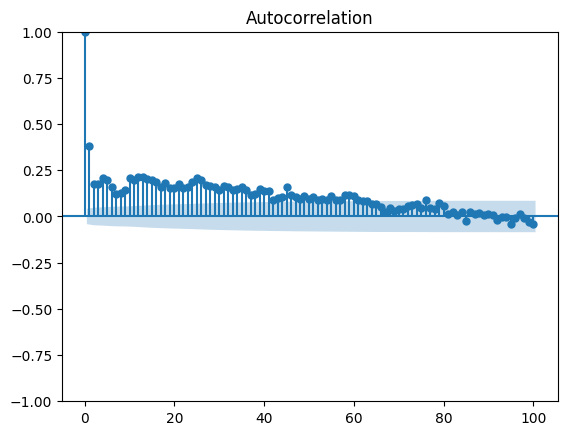

In [39]:
plot_acf(wTor_season['AvgWind'], lags=100)
plt.show()

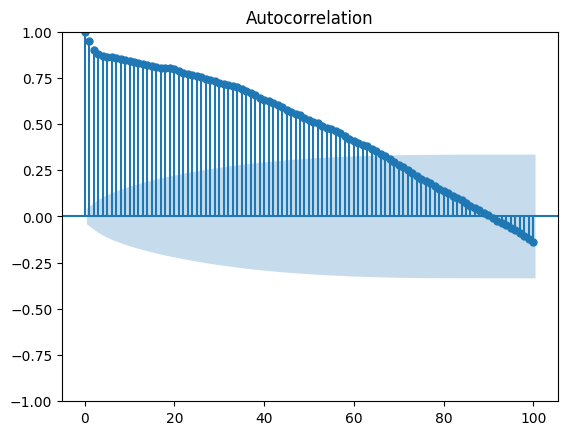

In [40]:
plot_acf(wTor_season['MinT'], lags=100)
plt.show()

Checking for Partial Auto Correlation Graph for Average Temp

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


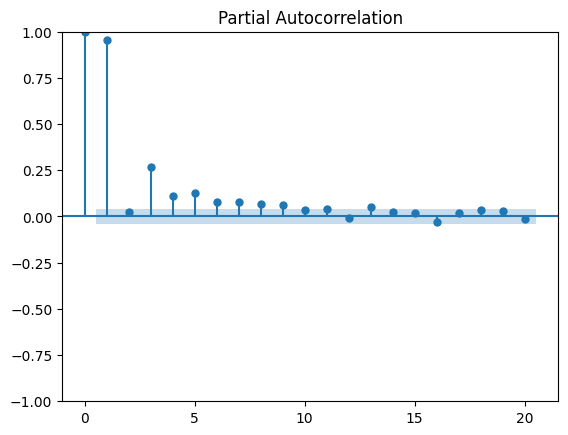

In [41]:
plot_pacf(wTor_season['AvgT'], lags=20)
plt.show()

Checking for Auto Correlation Graph for Average Wind

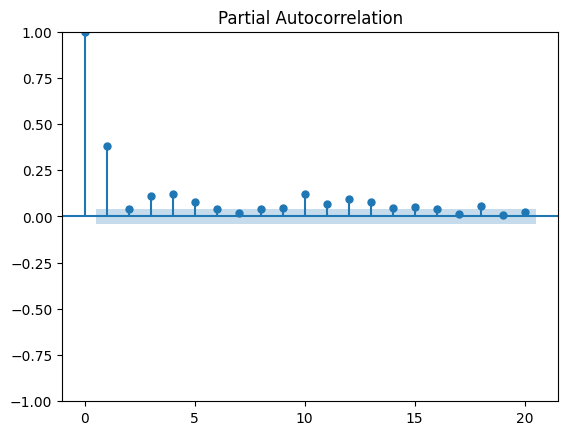

In [42]:
plot_pacf(wTor_season['AvgWind'], lags=20)
plt.show()

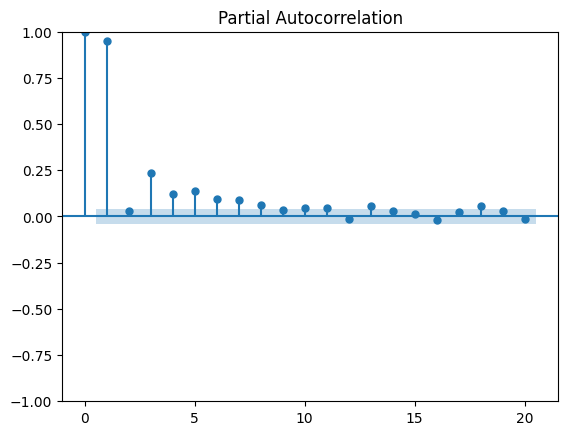

In [43]:
plot_pacf(wTor_season['MinT'], lags=20)
plt.show()

### Train Test Split of Data

Performing train test spilit on the data

In [44]:
train = wTor_season[:int(len(df)*0.90)]
test = wTor_season[int(len(df)*0.90):]

In [45]:
import pmdarima as pm

SARIMAX Model


Finding the best parameter values of p,d,q for SARIMAX model

In [46]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


### Akaike Information Criteria (AIC) Grid Search

Using Akaike Information Criteria to Find optimal parameters for Average Wind Series

In [47]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
aic = []
prm = []
prms = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.AvgWind,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aic.append(results.aic)
            prm.append(param)
            prms.append(param_seasonal)
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14892.16584187634
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13542.590787431443
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:12051.314901490687
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11102.320025772577
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:11925.260047295513
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11176.507471025467
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11486.46734883024
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11076.816338483342
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13410.937870494907
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12655.45001689946
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11954.154936916402
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10907.785931965598
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:11776.627387291759
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:10984.485860987166
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11381.002996399564
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10873.246143483755
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:11686.342314484813
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - 

Using Akaike Information Criteria to Find optimal parameters for Average Temp Series

In [48]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
aic = []
prm = []
prms = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.AvgT,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aic.append(results.aic)
            prm.append(param)
            prms.append(param_seasonal)
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:21316.947018706982
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:19051.10409669876
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:14565.421434460677
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:14317.198171439713
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:14563.064005314944
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:14418.34132253849
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:14300.756771395483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:14295.615032322097
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:18778.685842791336
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:16871.515820059674
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13558.104387312365
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:13168.816764460995
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:13553.059180862145
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:13256.240721989376
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:13169.98869518359
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:13142.640933165556
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:12324.28212389988
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - A

In [49]:
a = pd.DataFrame(columns=["Parms","sParms", "AIC"])
a["Parms"] = prm
a["sParms"] = prms
a["AIC"] = aic
#print(a.AIC.sort_values().head(60))

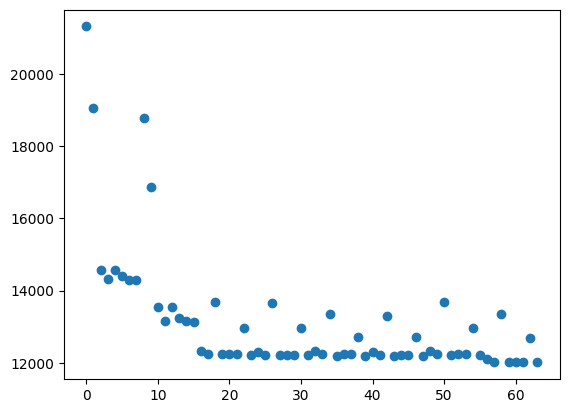

In [50]:
ys = a.AIC
xs = a.index
plt.scatter(xs,ys)
for x,y in zip(xs,ys):
    label = "{:.2f}".format(y)
    plt.plot(figsize=(16,30))

In [51]:
'''
residuals = train.AvgT.copy(deep=True)
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')
mod = ar_select_order(residuals, maxlag=40, ic='aic', old_names=True)
aic = []
for key, val in mod.aic.items():
    if key != 0:
        aic.append((key[-1], val))
aic.sort()    
x,y = [x for x,y in aic],[y for x,y in aic]
plt.scatter(x, y)
plt.plot([0,40],[y[15],y[15]], 'tab:orange')
plt.text(3,y[15]+0.002, '{0}'.format(round(y[15],3)),color='tab:orange')
plt.plot([0,40],[y[20],y[20]], 'k--')
plt.text(3,y[20]-0.004, '{0}'.format(round(y[20],3)))
plt.title("AIC Criterion")
plt.xlabel("Lags in AR Model")
plt.ylabel("AIC")
plt.show()
'''

'\nresiduals = train.AvgT.copy(deep=True)\nresiduals.index = pd.DatetimeIndex(residuals.index).to_period(\'D\')\nmod = ar_select_order(residuals, maxlag=40, ic=\'aic\', old_names=True)\naic = []\nfor key, val in mod.aic.items():\n    if key != 0:\n        aic.append((key[-1], val))\naic.sort()    \nx,y = [x for x,y in aic],[y for x,y in aic]\nplt.scatter(x, y)\nplt.plot([0,40],[y[15],y[15]], \'tab:orange\')\nplt.text(3,y[15]+0.002, \'{0}\'.format(round(y[15],3)),color=\'tab:orange\')\nplt.plot([0,40],[y[20],y[20]], \'k--\')\nplt.text(3,y[20]-0.004, \'{0}\'.format(round(y[20],3)))\nplt.title("AIC Criterion")\nplt.xlabel("Lags in AR Model")\nplt.ylabel("AIC")\nplt.show()\n'

### Univeriate Model Fitting (SARIMAX) 

#### Univariate : With Walk forward Method : 

Univerate SARIMAX Model fitting with Walk forward method


<b> Walk Forward Method </b>: In this method, we first forecast on 7 days and then after making predictions, we add that 7 days data to training data and make forecast of next 7 days. That way, in total we forecast for 28 days.

In [52]:
def univerate_SarimaX(s, n):
    predictions = np.array([])
    train, test = s[:n], s[n:]
    day_list = [7,14,21,28] # weeks 1,2,3,4
    for i in day_list:
        model = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 30)).fit(max_iter = 50,
                                          method = 'powell')
        # Forecasting for next 7 days
        forecast = model.get_forecast(steps = 7, dynamic=False)
        predictions = np.concatenate((predictions, forecast), 
                                     axis=None)
        j = i-7
        model.plot_diagnostics(figsize=(15, 12))
        train = np.concatenate((train,test[j:i]), axis=None) # adding it into training data
    return predictions

In [53]:
def get_vals(preds):
  pp = list(preds[0].predicted_mean)
  pp.append(list(preds[1].predicted_mean))
  pp.append(list(preds[2].predicted_mean))
  pp.append(list(preds[3].predicted_mean))
  return pp

Forecasting Univerate Average Temporature with Walk forward Method

Optimization terminated successfully.
         Current function value: 3.080517
         Iterations: 4
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: 3.080841
         Iterations: 4
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 3.080801
         Iterations: 4
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 3.080106
         Iterations: 4
         Function evaluations: 183


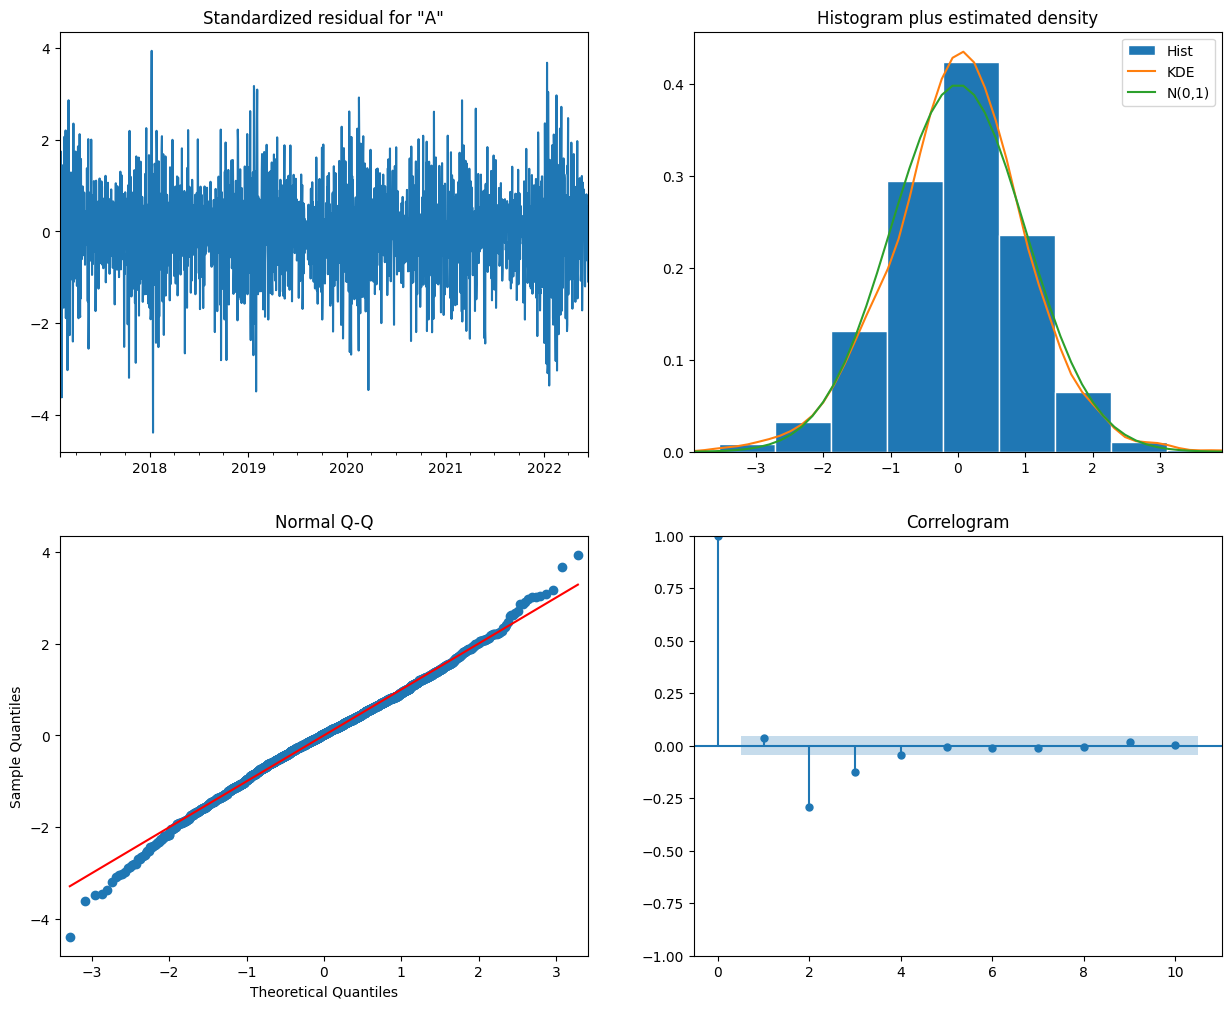

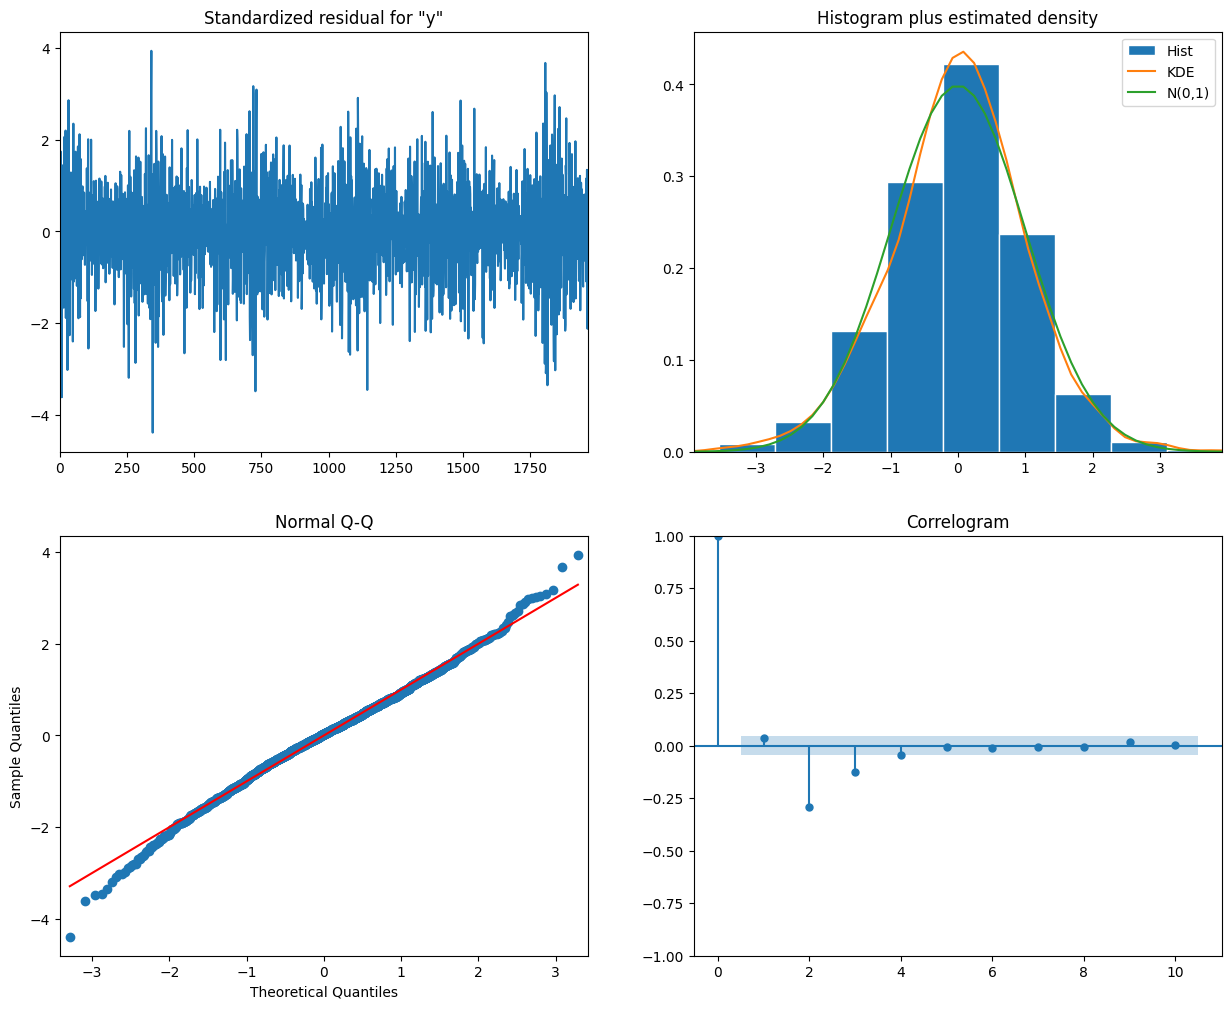

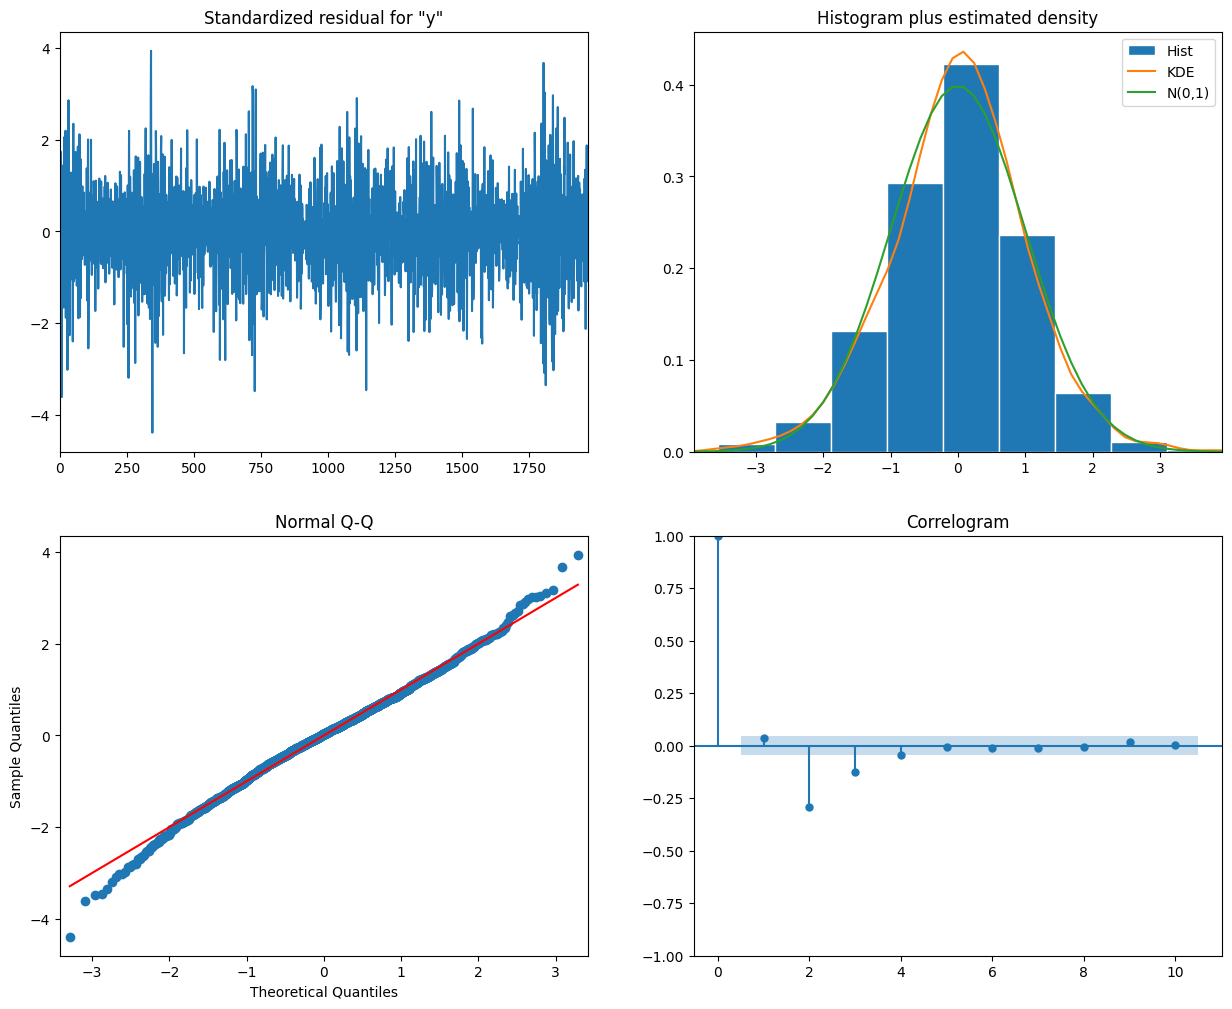

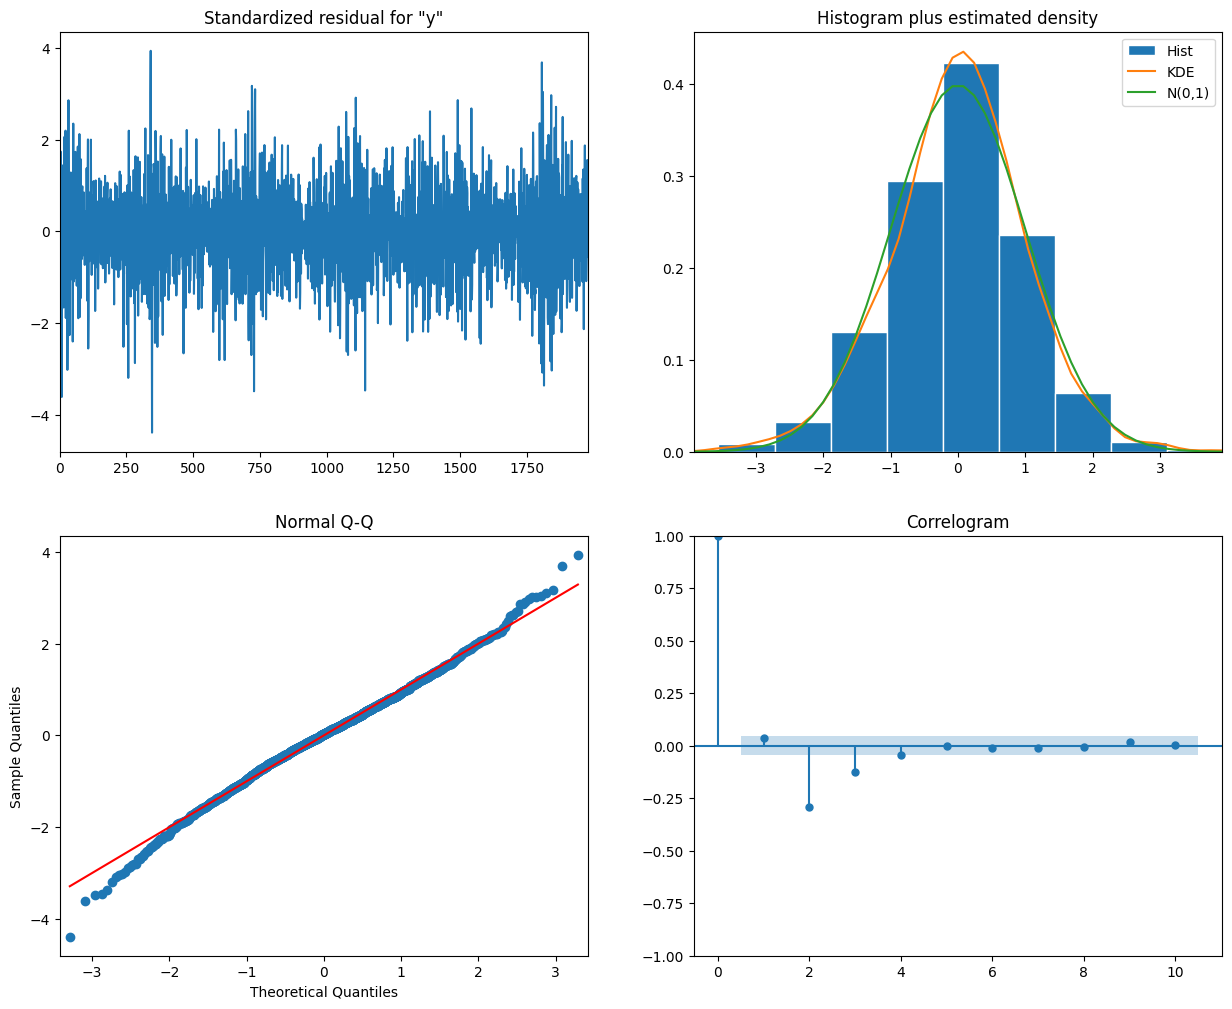

In [54]:
preds = univerate_SarimaX(wTor_season.AvgT,1990)
pp = get_vals(preds)

In [55]:
dates = pd.date_range(wTor_season.iloc[1990].name, periods=28, freq='1D')

In [56]:
predictions = pd.DataFrame(data=pd.Series(pp).explode().reset_index())

In [57]:
predictions.drop("index",axis=1, inplace=True)
predictions.set_index(dates,inplace=True)

Plotting the Average Temperature Predictions and Actual Data

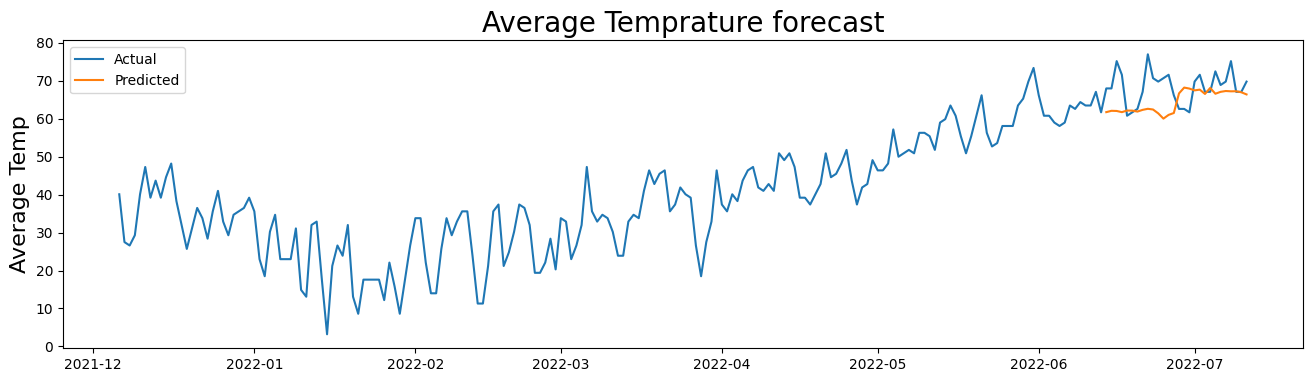

In [58]:
plt.figure(figsize=(16,4))
plt.plot(wTor_season.AvgT[1800:2018], label="Actual")

plt.plot(predictions, label="Predicted")
plt.title('Average Temprature forecast', fontsize=20)
plt.ylabel('Average Temp', fontsize=16)
plt.legend()

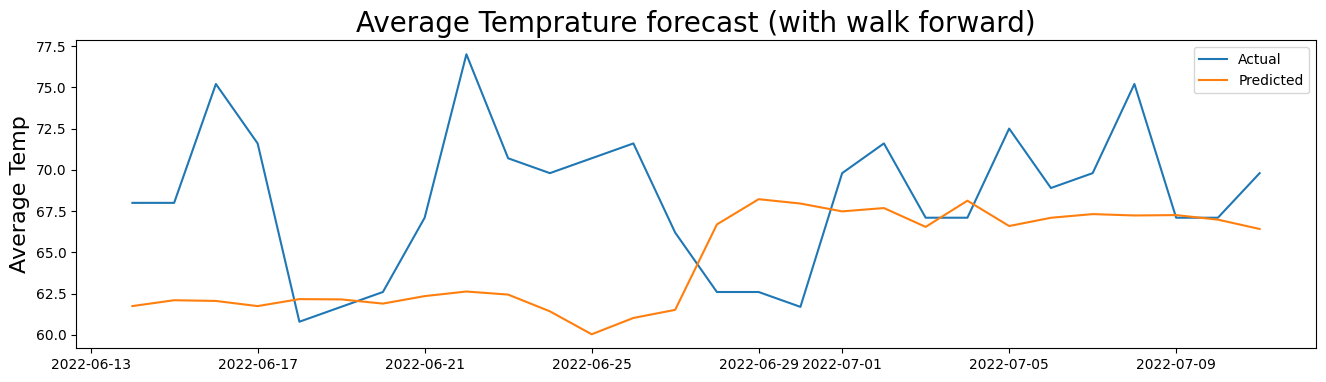

In [59]:
plt.figure(figsize=(16,4))
plt.plot(wTor_season.AvgT[1990:2018], label="Actual")

plt.plot(predictions, label="Predicted")
plt.title('Average Temprature forecast (with walk forward)', fontsize=20)
plt.ylabel('Average Temp', fontsize=16)
plt.legend()

Checking for the model performance

In [60]:
model_performance(wTor_season.AvgT[1990:2018].values,predictions.values)


RMSE : 6.33
Normalized RMSE : 0.39


Forecasting Univerate Average Wind with Walk forward Method




Optimization terminated successfully.
         Current function value: 2.728061
         Iterations: 4
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 2.729830
         Iterations: 4
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: 2.729272
         Iterations: 4
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 2.728387
         Iterations: 4
         Function evaluations: 179


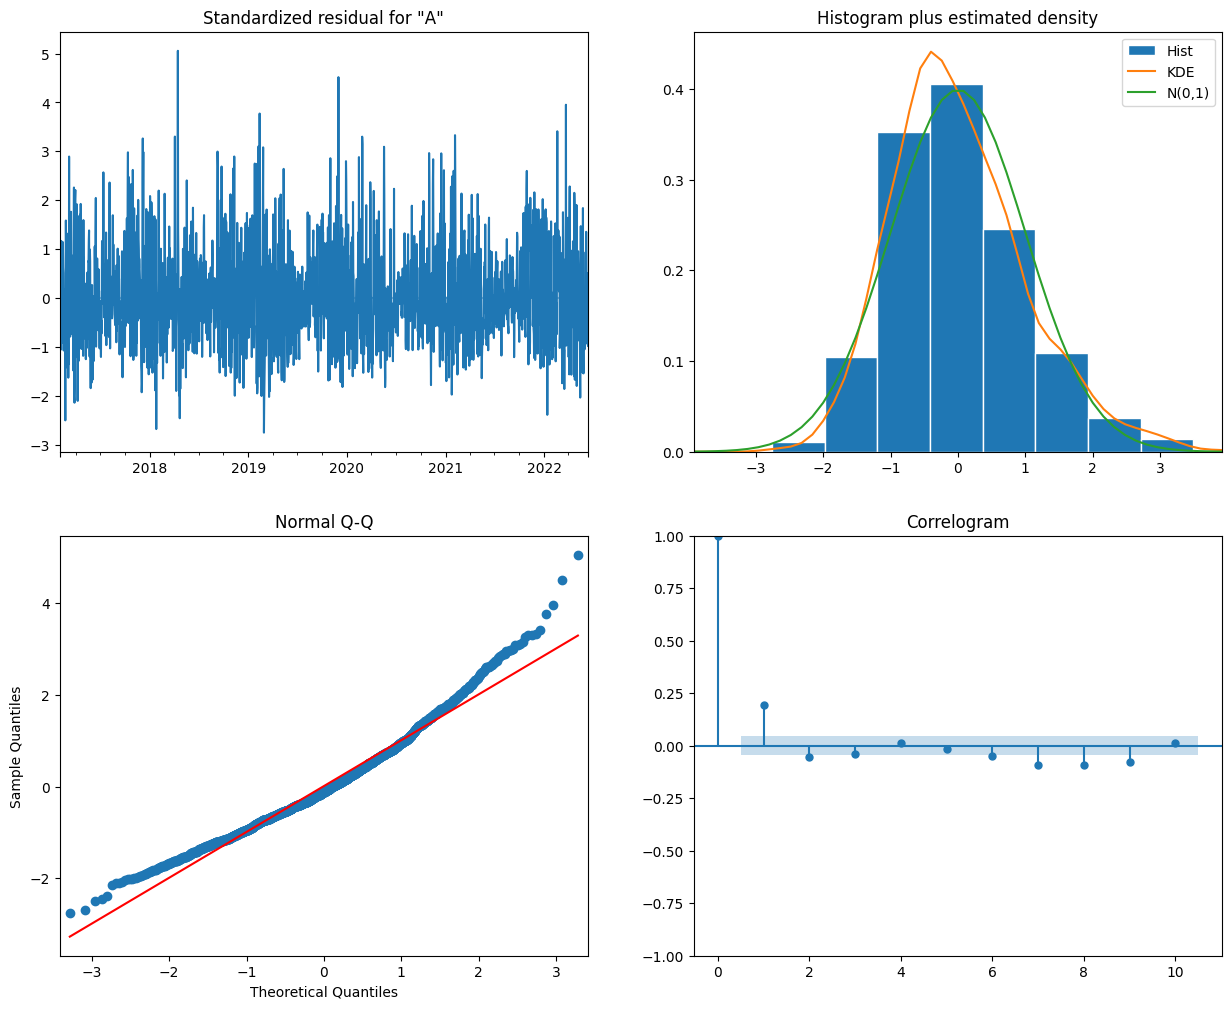

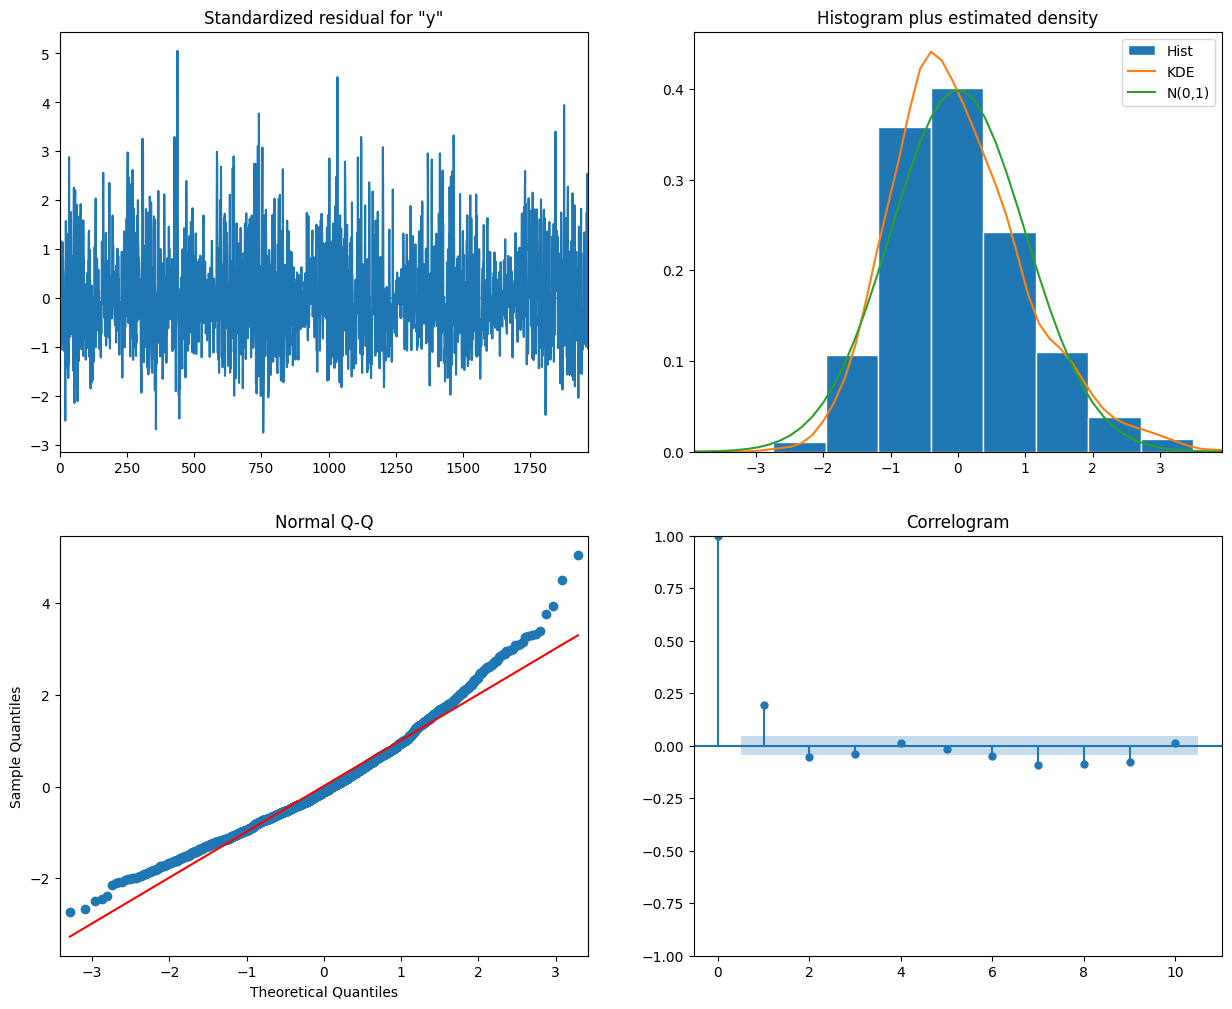

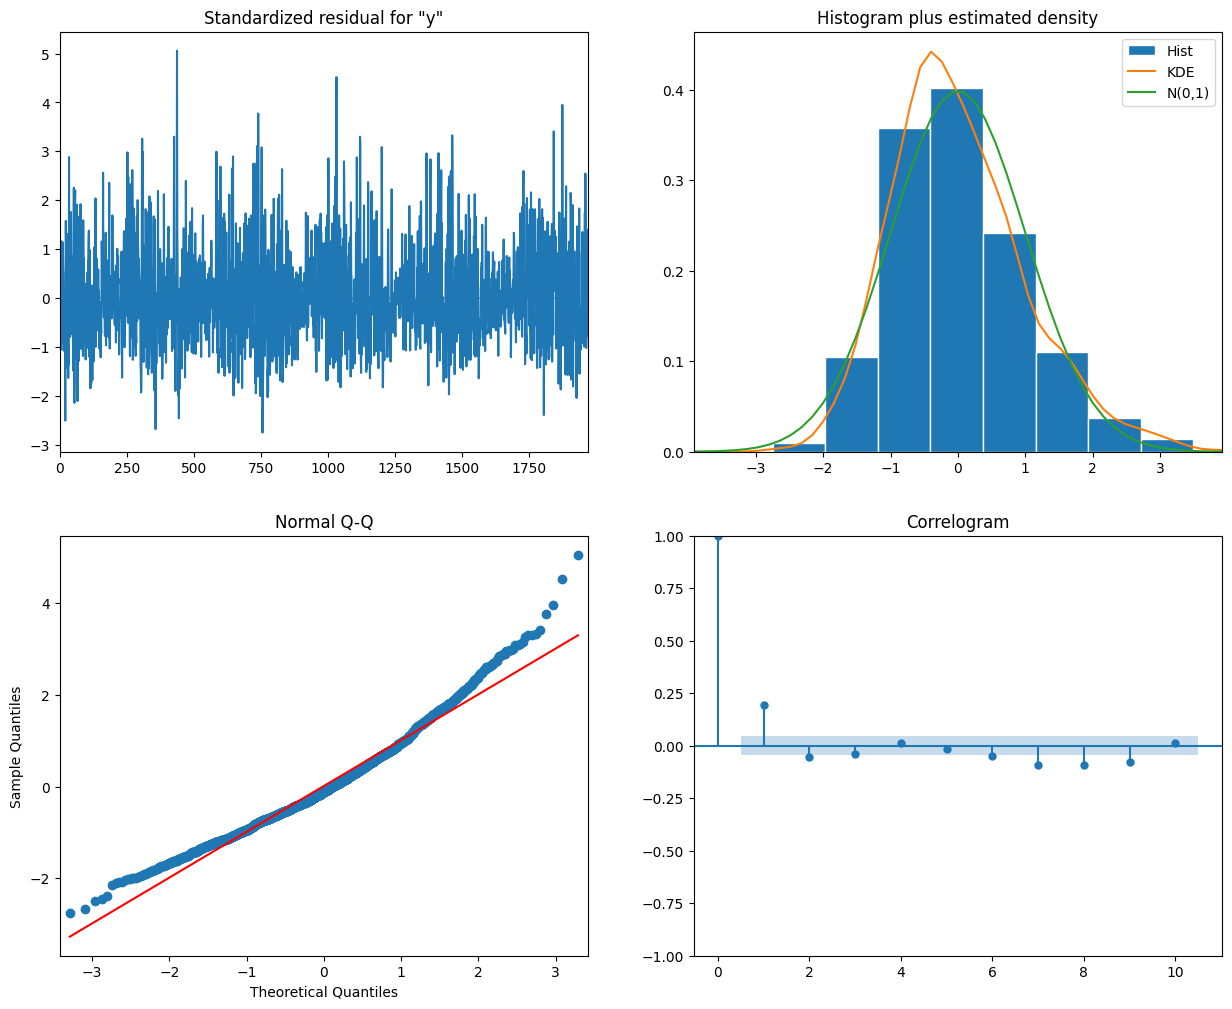

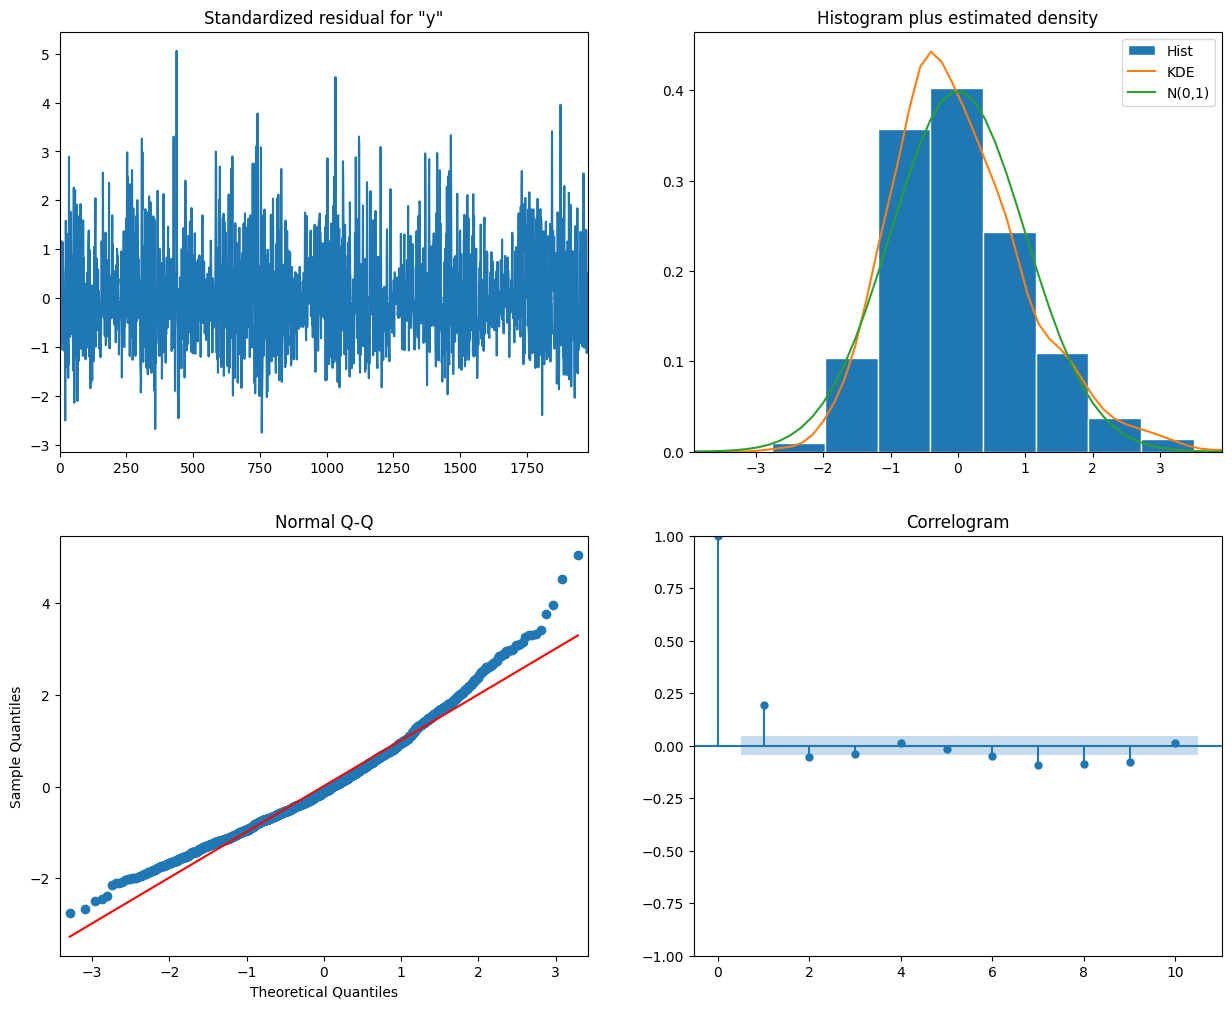

In [61]:
preds = univerate_SarimaX(wTor_season.AvgWind,1990)
pp = get_vals(preds)

In [62]:
predictions = pd.DataFrame(data=pd.Series(pp).explode().reset_index())

In [63]:
predictions.drop("index",axis=1, inplace=True)
predictions.set_index(dates,inplace=True)

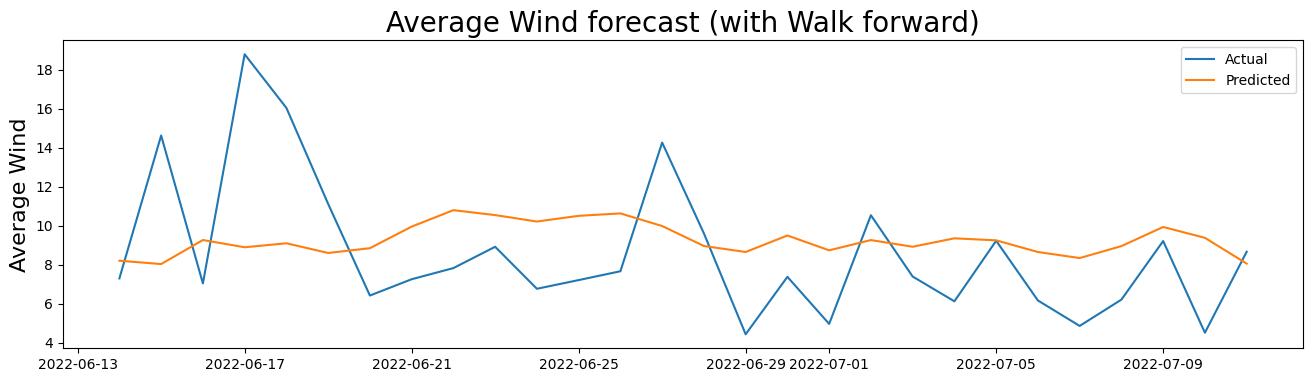

In [64]:
plt.figure(figsize=(16,4))
plt.plot(wTor_season.AvgWind[1990:2018], label="Actual")

plt.plot(predictions, label="Predicted")
plt.title('Average Wind forecast (with Walk forward)', fontsize=20)
plt.ylabel('Average Wind', fontsize=16)
plt.legend()

In [65]:
model_performance(wTor_season.AvgWind[1990:2018].values,predictions.values)


RMSE : 3.62
Normalized RMSE : 0.25


#### Univariate : Without Walk Forward Method

Forecasting Univerate Average Temperature without Walk forward Method


In [66]:
model = sm.tsa.statespace.SARIMAX(train.AvgT, order=(0,1,1),
                                seasonal_order=(1,1,1,30), simple_differencing=False,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                ).fit(max_iter = 50,
                                          method = 'powell')
                                          #method='innovations_mle', low_memory=True)
        
        # Forecast daily loads for week i
forecast1 = model.get_forecast(steps = 30, dynamic=False)

Optimization terminated successfully.
         Current function value: 3.017680
         Iterations: 3
         Function evaluations: 138


<Axes: title={'center': 'Correlogram'}>

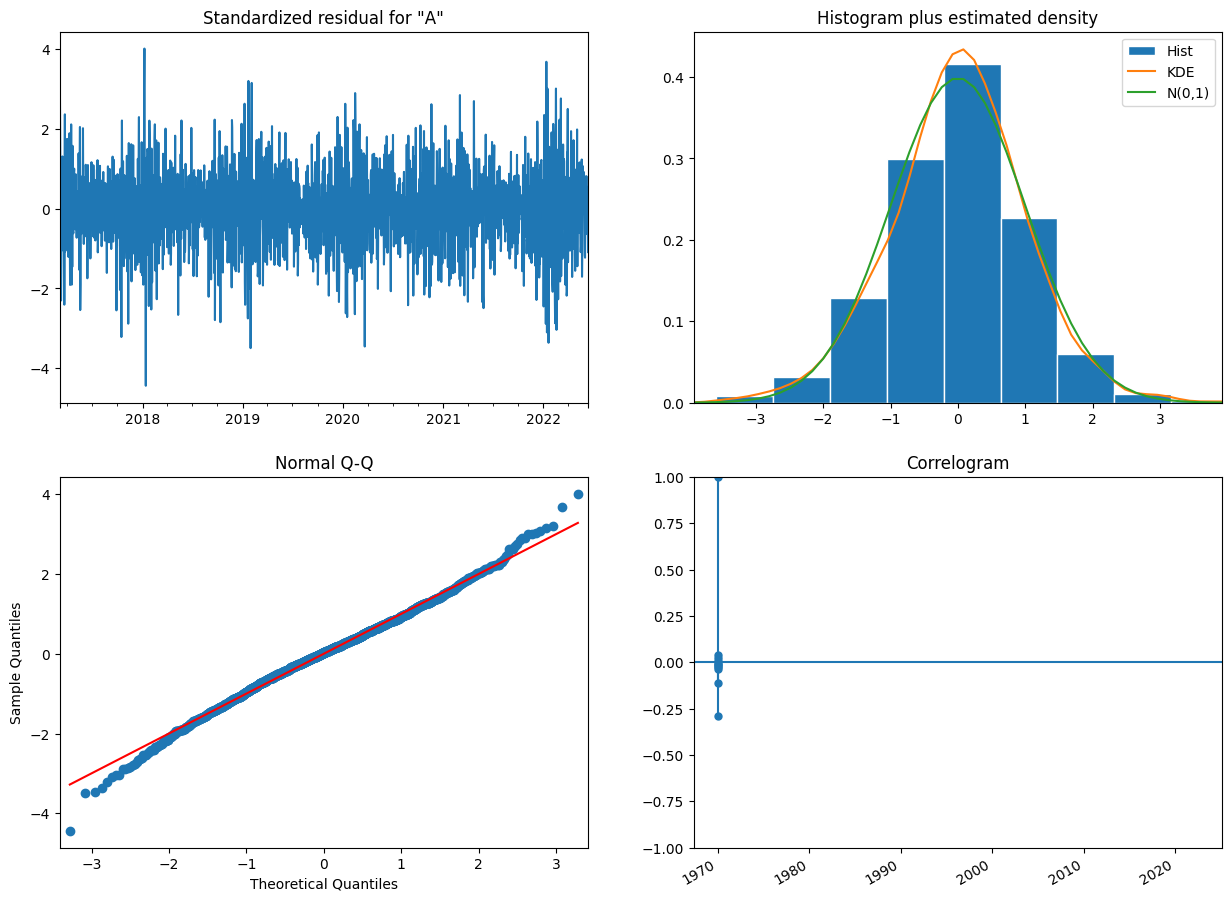

In [67]:
model.plot_diagnostics(figsize=(15, 12))
forecast1.predicted_mean.plot()

Univeriate Forecast evaluation on Temperature without Walk Forward

In [68]:
print(model_performance(test.AvgT[:30],forecast1.predicted_mean))


RMSE : 8.07
Normalized RMSE : 0.5
None


In [69]:
model = sm.tsa.statespace.SARIMAX(train.AvgWind , order=(0,1,1),
                                seasonal_order=(1,1,1,30), simple_differencing=False,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                ).fit(max_iter = 50,
                                          method = 'powell')
                                          #method='innovations_mle', low_memory=True)
        
        # Forecast daily loads for week i
forecast1 = model.get_forecast(steps = 30, dynamic=False)

Optimization terminated successfully.
         Current function value: 2.677364
         Iterations: 5
         Function evaluations: 271


<Axes: title={'center': 'Correlogram'}>

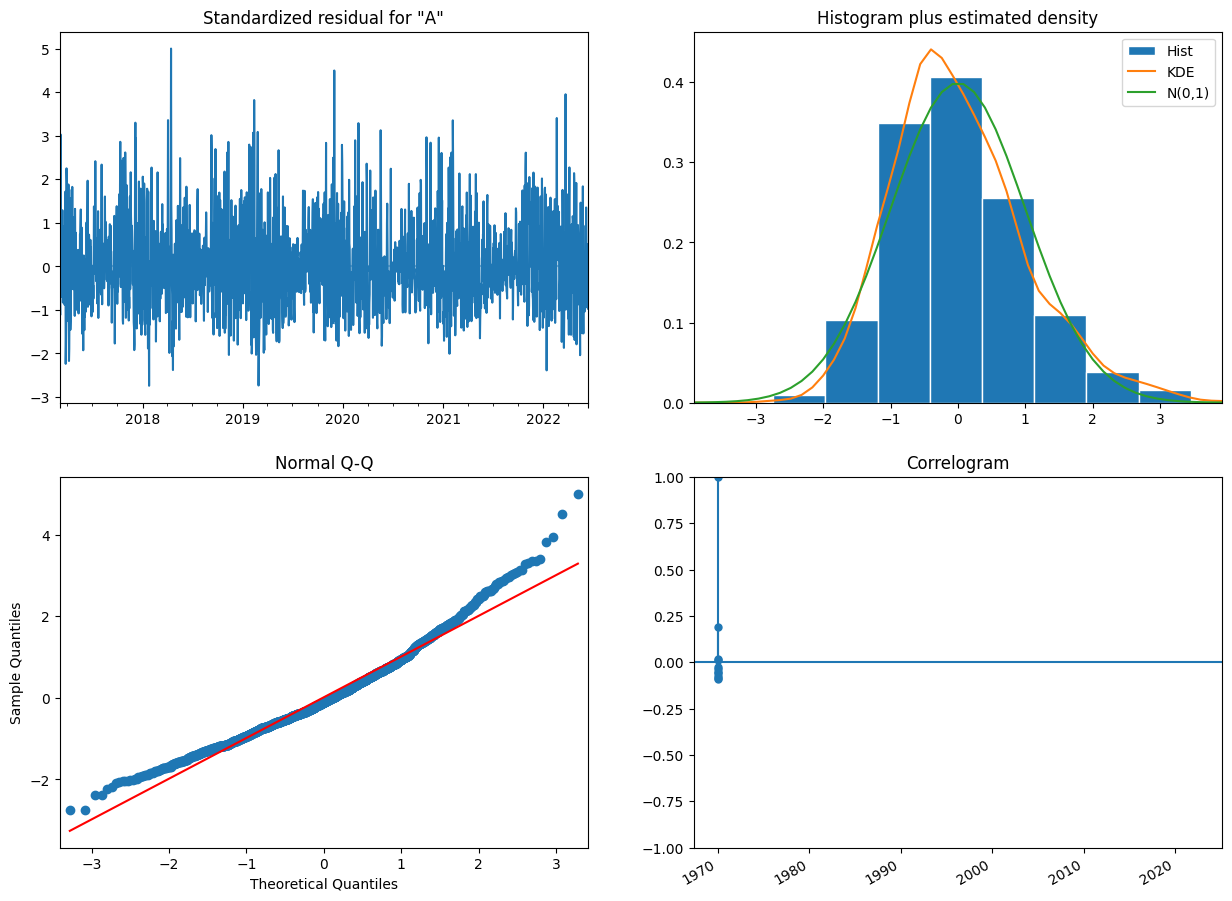

In [70]:
model.plot_diagnostics(figsize=(15, 12))
forecast1.predicted_mean.plot()

Univeriate Forecast evaluation on Wind without Walk Forward

In [71]:
print(model_performance(test.AvgWind[:30],forecast1.predicted_mean))


RMSE : 3.55
Normalized RMSE : 0.25
None


### Multivariate Model Fitting (SARIMAX)

#### Multivariate : With Walk Forward Method


Multiveriate SarmiaX Forecasting temperature with Average wind as Exogenious feature (with Walk Forward)



In [72]:
def Multivariate_temp_wf(s, n,ex):
    predictions = np.array([])
    mape_list = []
    train, test = s[:n], s[n:]
    extrain, extest = ex[:n], ex[n:]
    day_list = [7,14,21,28] # weeks 1,2,3,4
    for i in day_list:
        model = sm.tsa.statespace.SARIMAX(train,exog=extrain, order=(1, 1, 1),
                                seasonal_order=(1, 1, 1,30)).fit(max_iter = 50,
                                          method = 'powell')
        
        forecast = model.get_forecast(steps = 7, dynamic=False, exog=extest[:7])
        predictions = np.concatenate((predictions, forecast), 
                                     axis=None)
        j = i-7
        model.plot_diagnostics(figsize=(15, 12))
        train = np.concatenate((train,test[j:i]), axis=None)
        extrain = np.concatenate((extrain,extest[j:i]), axis=None)
    return predictions#, mape_list


Optimization terminated successfully.
         Current function value: 3.029942
         Iterations: 5
         Function evaluations: 315
Optimization terminated successfully.
         Current function value: 3.030211
         Iterations: 5
         Function evaluations: 315
Optimization terminated successfully.
         Current function value: 3.030145
         Iterations: 5
         Function evaluations: 316
Optimization terminated successfully.
         Current function value: 3.029371
         Iterations: 5
         Function evaluations: 317


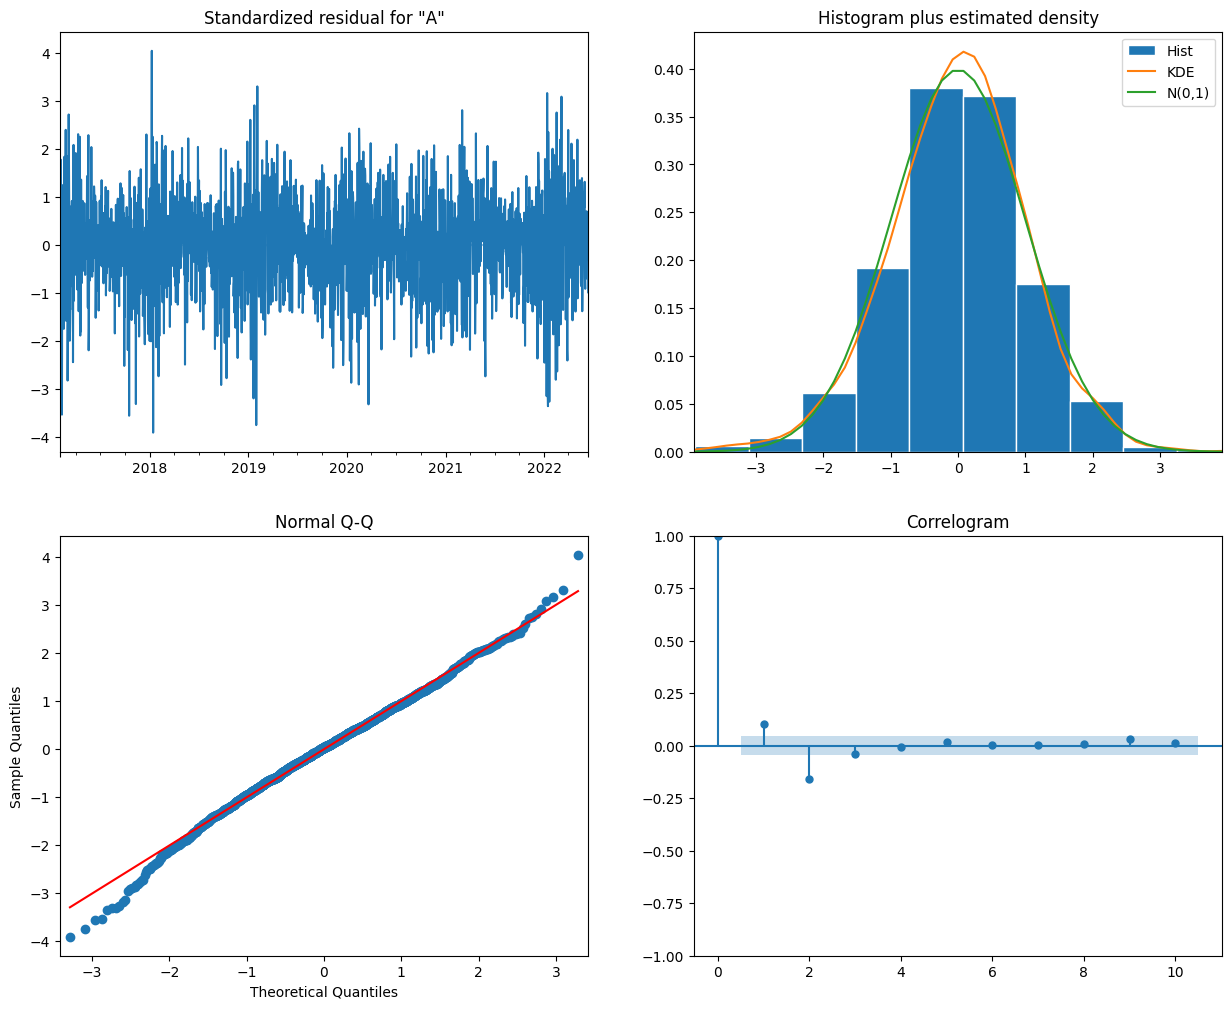

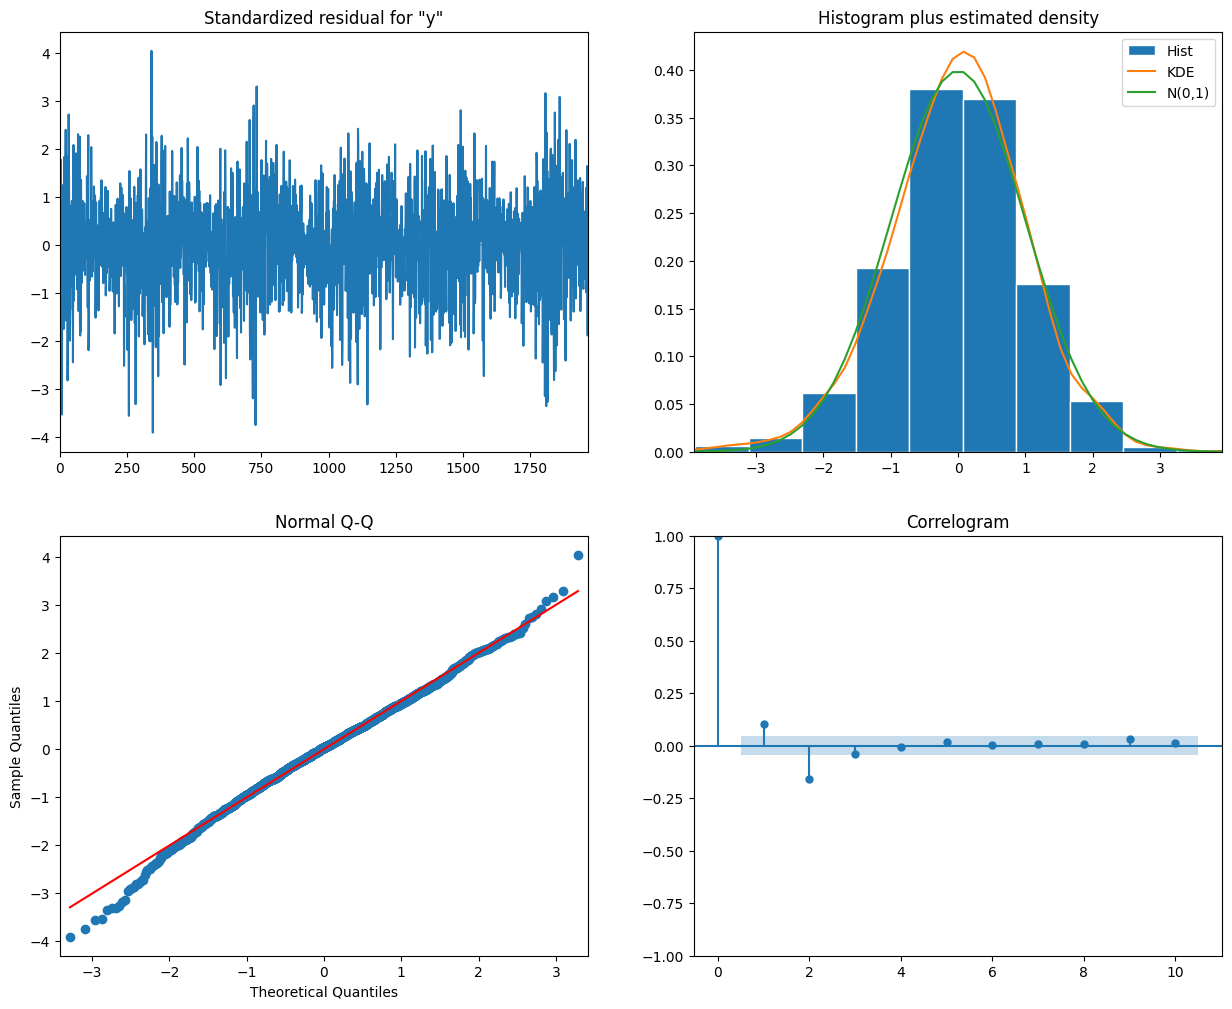

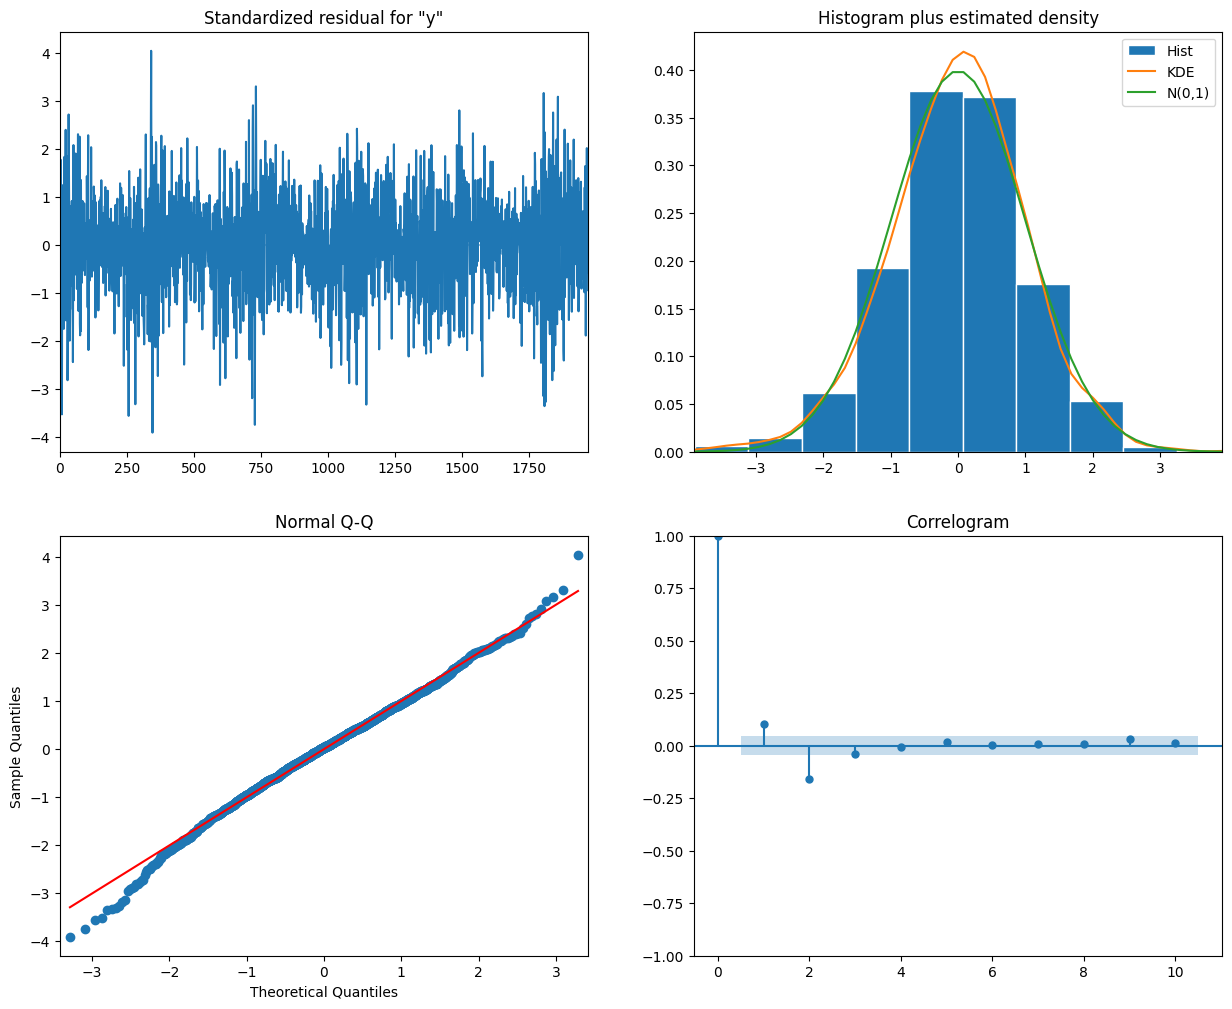

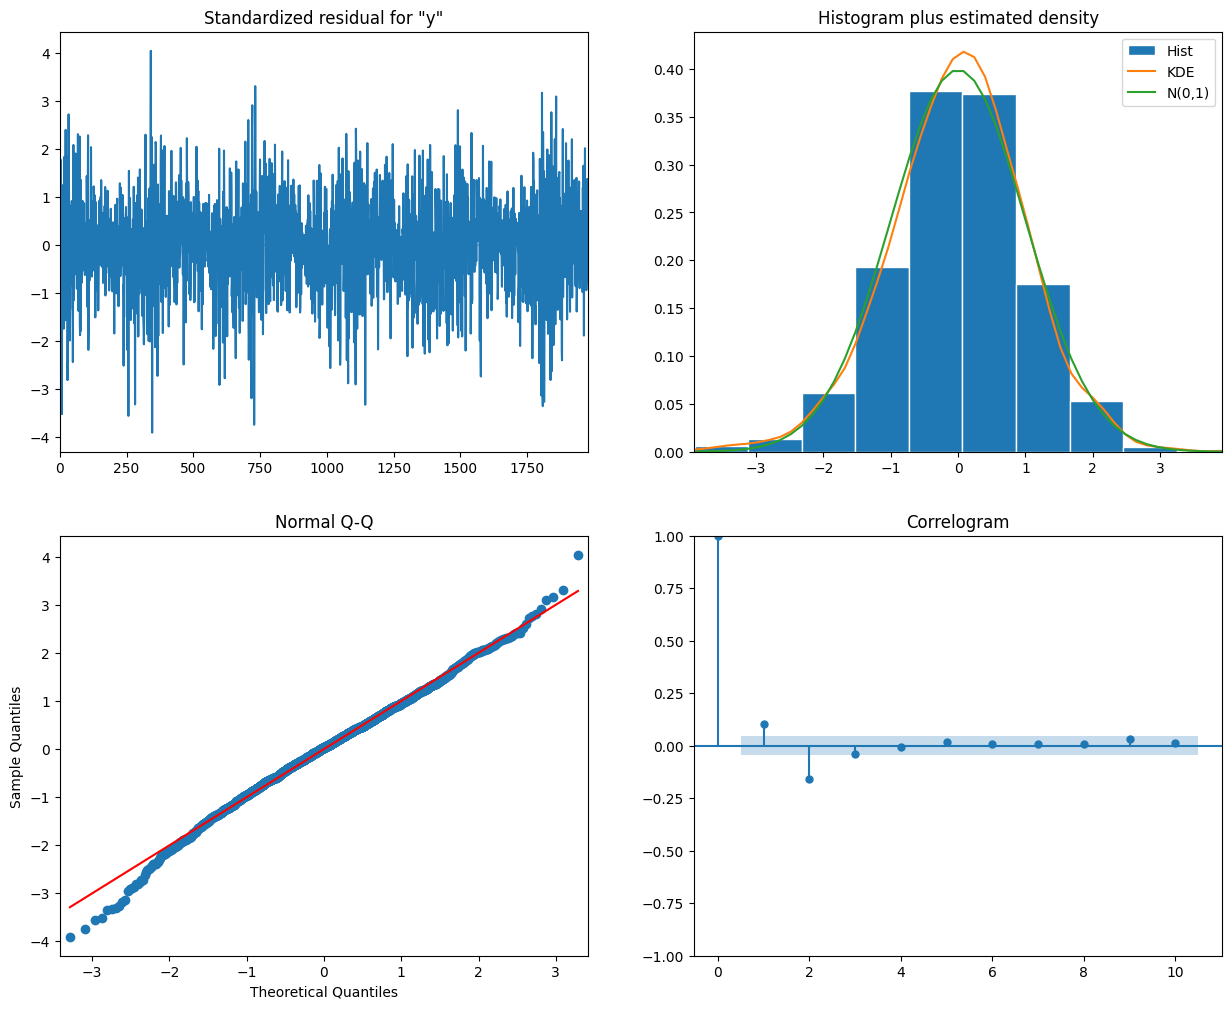

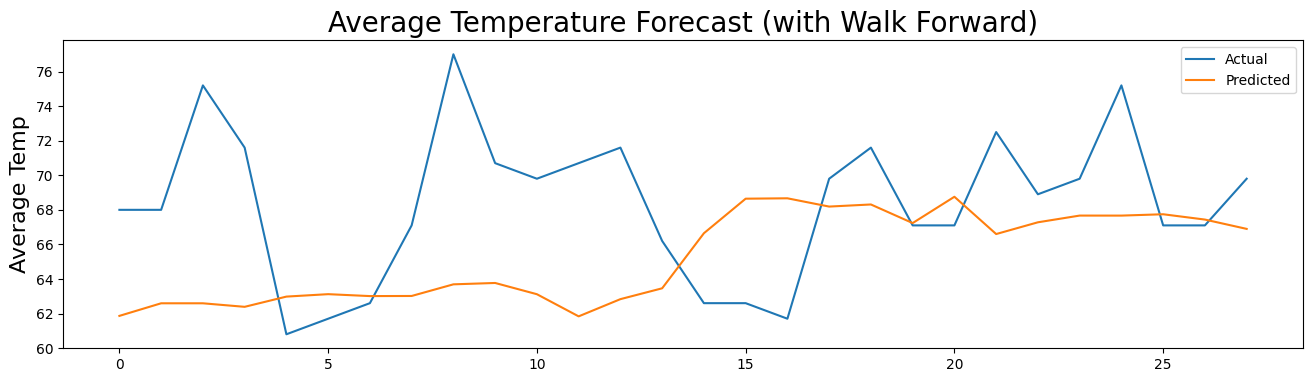

In [73]:
preds = Multivariate_temp_wf(wTor_season.AvgT,1990,wTor_season.AvgWind)
pp = list(preds[0].predicted_mean)
pp.append(list(preds[1].predicted_mean))
pp.append(list(preds[2].predicted_mean))
pp.append(list(preds[3].predicted_mean))

plt.figure(figsize=(16,4))
plt.plot(wTor_season.AvgT[1990:2018].values, label="Actual")
plt.plot(pd.Series(pp).explode().reset_index()[0].values, label="Predicted")
plt.title('Average Temperature Forecast (with Walk Forward)', fontsize=20)
plt.ylabel('Average Temp', fontsize=16)
plt.legend()


In [74]:
model_performance(wTor_season.AvgT[1990:2018].values,pd.Series(pp).explode().reset_index()[0].values)


RMSE : 5.95
Normalized RMSE : 0.37


Multiveriate SarmiaX Forecasting temperature with Month as Exogenious feature (with Walk Forward)

Optimization terminated successfully.
         Current function value: 3.029547
         Iterations: 5
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: 3.029812
         Iterations: 5
         Function evaluations: 321
Optimization terminated successfully.
         Current function value: 3.029747
         Iterations: 5
         Function evaluations: 321
Optimization terminated successfully.
         Current function value: 3.028987
         Iterations: 5
         Function evaluations: 319


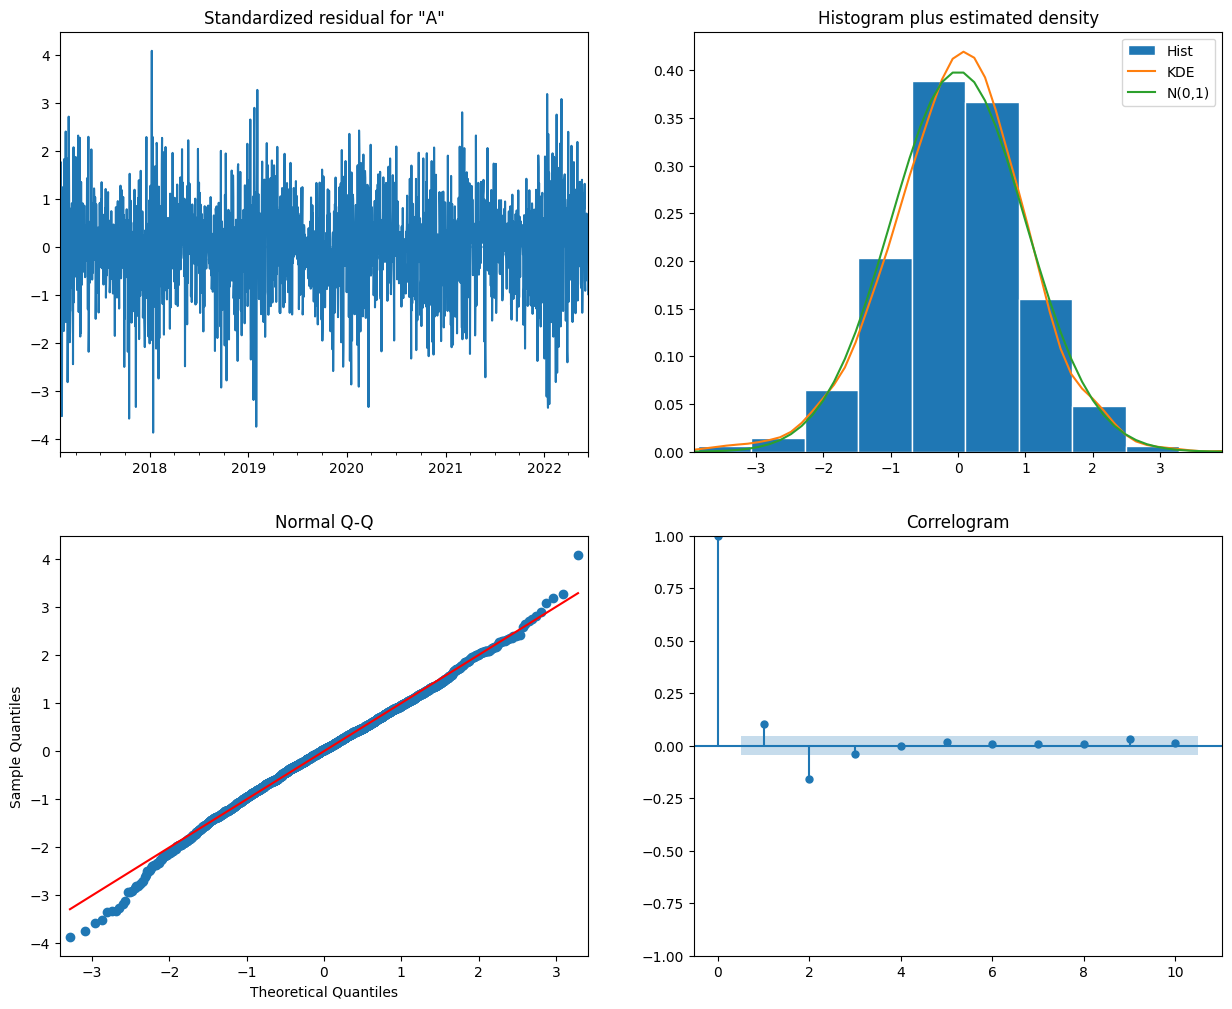

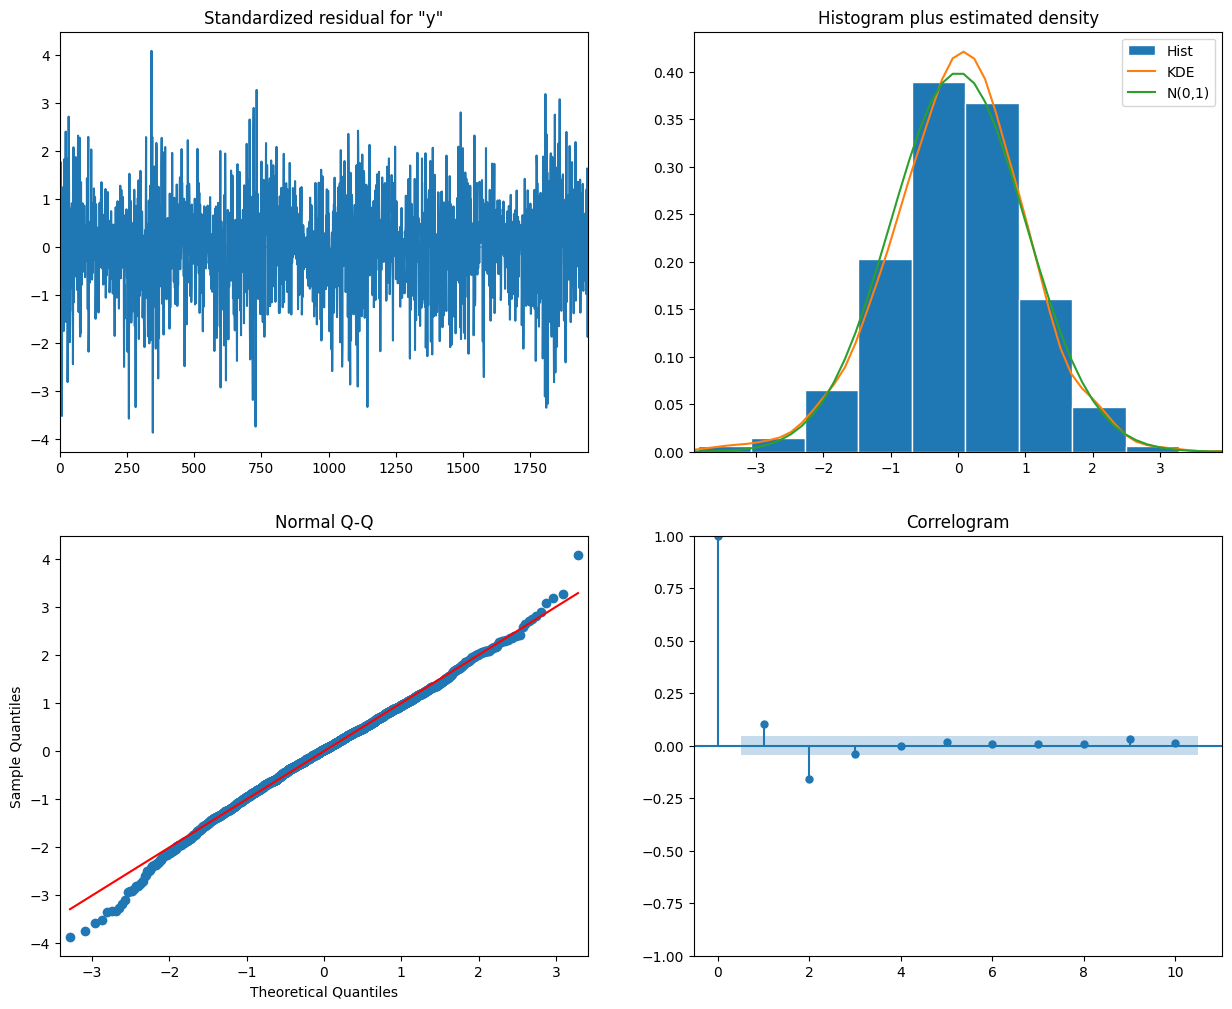

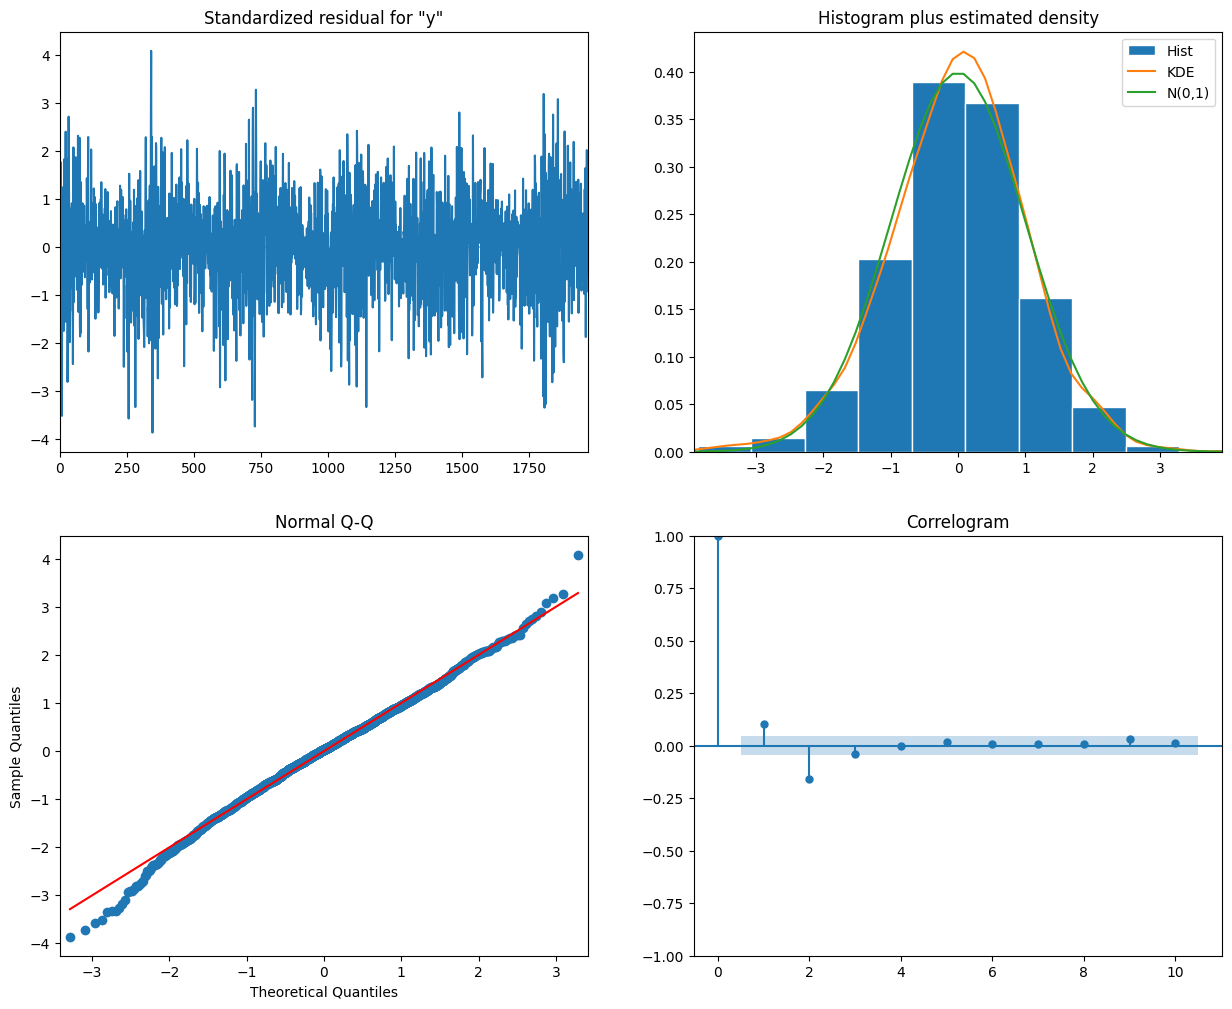

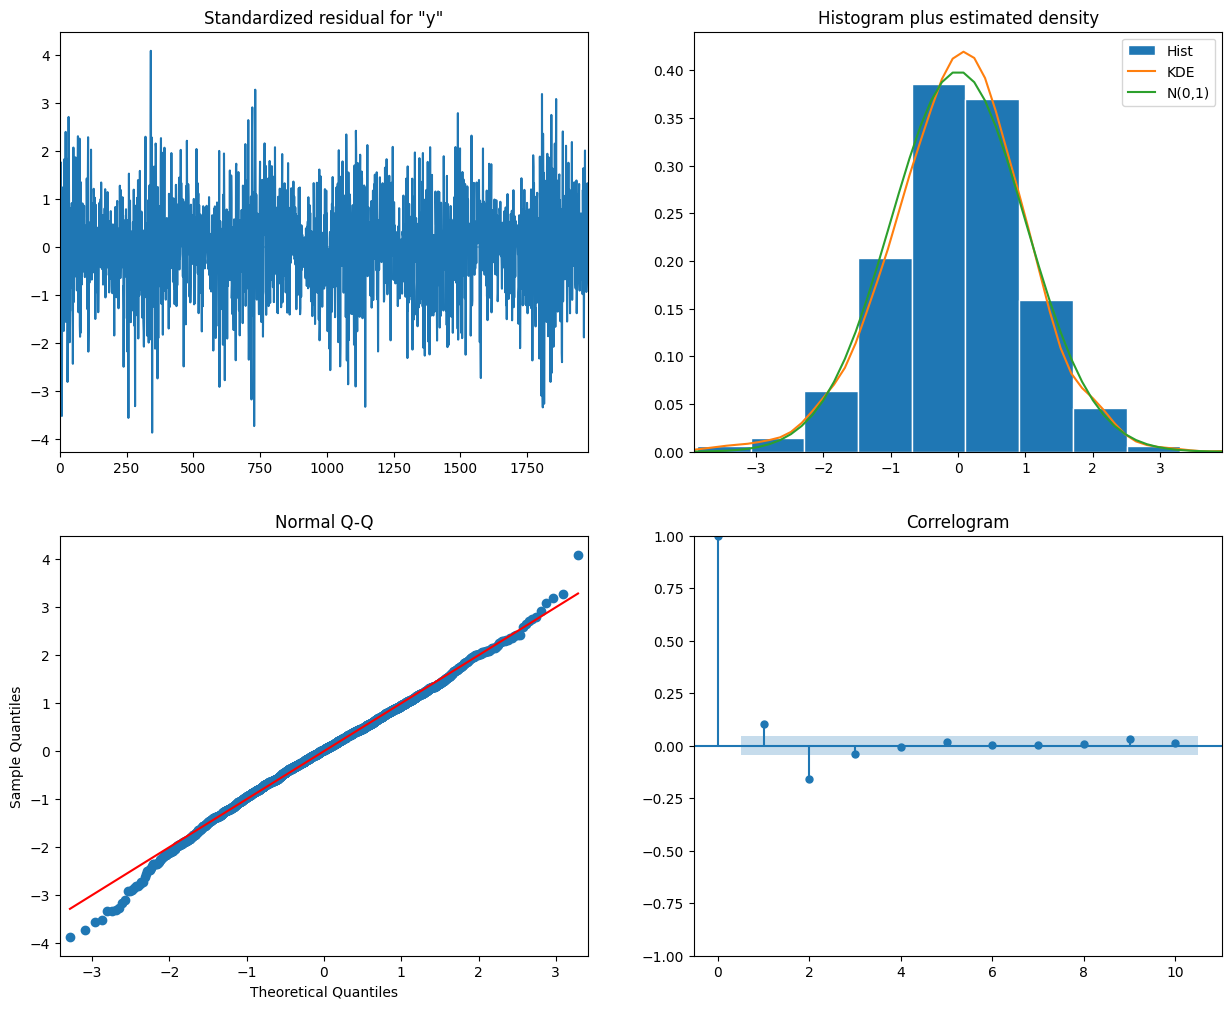

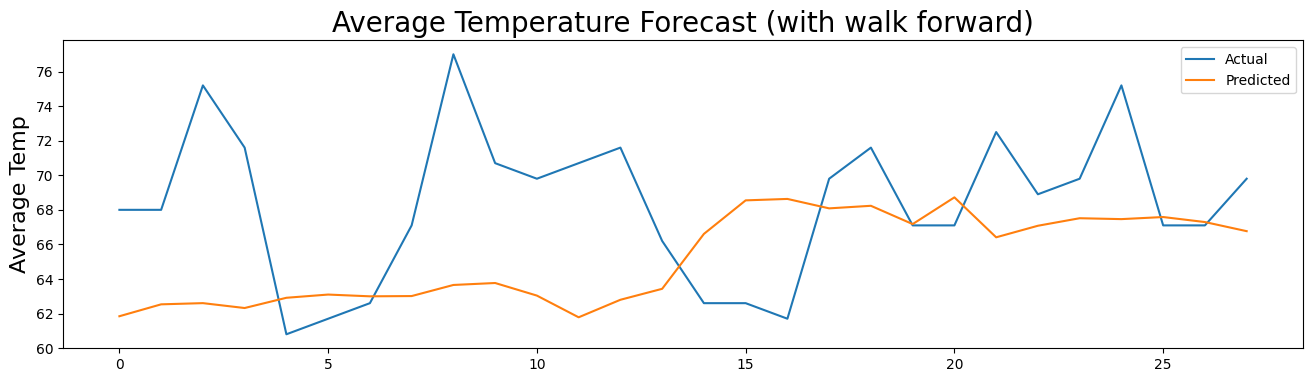

In [75]:
preds = Multivariate_temp_wf(wTor_season.AvgT,1990,wTor_season.month)
pp = list(preds[0].predicted_mean)
pp.append(list(preds[1].predicted_mean))
pp.append(list(preds[2].predicted_mean))
pp.append(list(preds[3].predicted_mean))


plt.figure(figsize=(16,4))
plt.plot(wTor_season.AvgT[1990:2018].values, label="Actual")
plt.plot(pd.Series(pp).explode().reset_index()[0].values, label="Predicted")
plt.title('Average Temperature Forecast (with walk forward)', fontsize=20)
plt.ylabel('Average Temp', fontsize=16)
plt.legend()


In [76]:
model_performance(wTor_season.AvgT[1990:2018].values,pd.Series(pp).explode().reset_index()[0].values)


RMSE : 5.99
Normalized RMSE : 0.37


Multiveriate SarmiaX Forecasting Wind with Month as Exogenious feature (with Walk Forward)



In [77]:
def Multivariate_wind_wf(s, n,ex):
    predictions = np.array([])
    mape_list = []
    train, test = s[:n], s[n:]
    extrain, extest = ex[:n], ex[n:]

    day_list = [7,14,21,28] # weeks 1,2,3,4
    for i in day_list:
        model = sm.tsa.statespace.SARIMAX(train,exog=extrain, order=(1, 1, 1),
                                seasonal_order=(1, 1, 1,7)).fit(max_iter = 50,
                                          method = 'powell')
        
        forecast = model.get_forecast(steps = 7, dynamic=False, exog=extest[:7])
        predictions = np.concatenate((predictions, forecast), 
                                     axis=None)
        j = i-7
      
        model.plot_diagnostics(figsize=(15, 12))
        train = np.concatenate((train,test[j:i]), axis=None)
        extrain = np.concatenate((extrain,extest[j:i]), axis=None)
    return predictions


Optimization terminated successfully.
         Current function value: 2.748505
         Iterations: 4
         Function evaluations: 308
Optimization terminated successfully.
         Current function value: 2.749108
         Iterations: 4
         Function evaluations: 305
Optimization terminated successfully.
         Current function value: 2.748692
         Iterations: 4
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: 2.748735
         Iterations: 4
         Function evaluations: 314


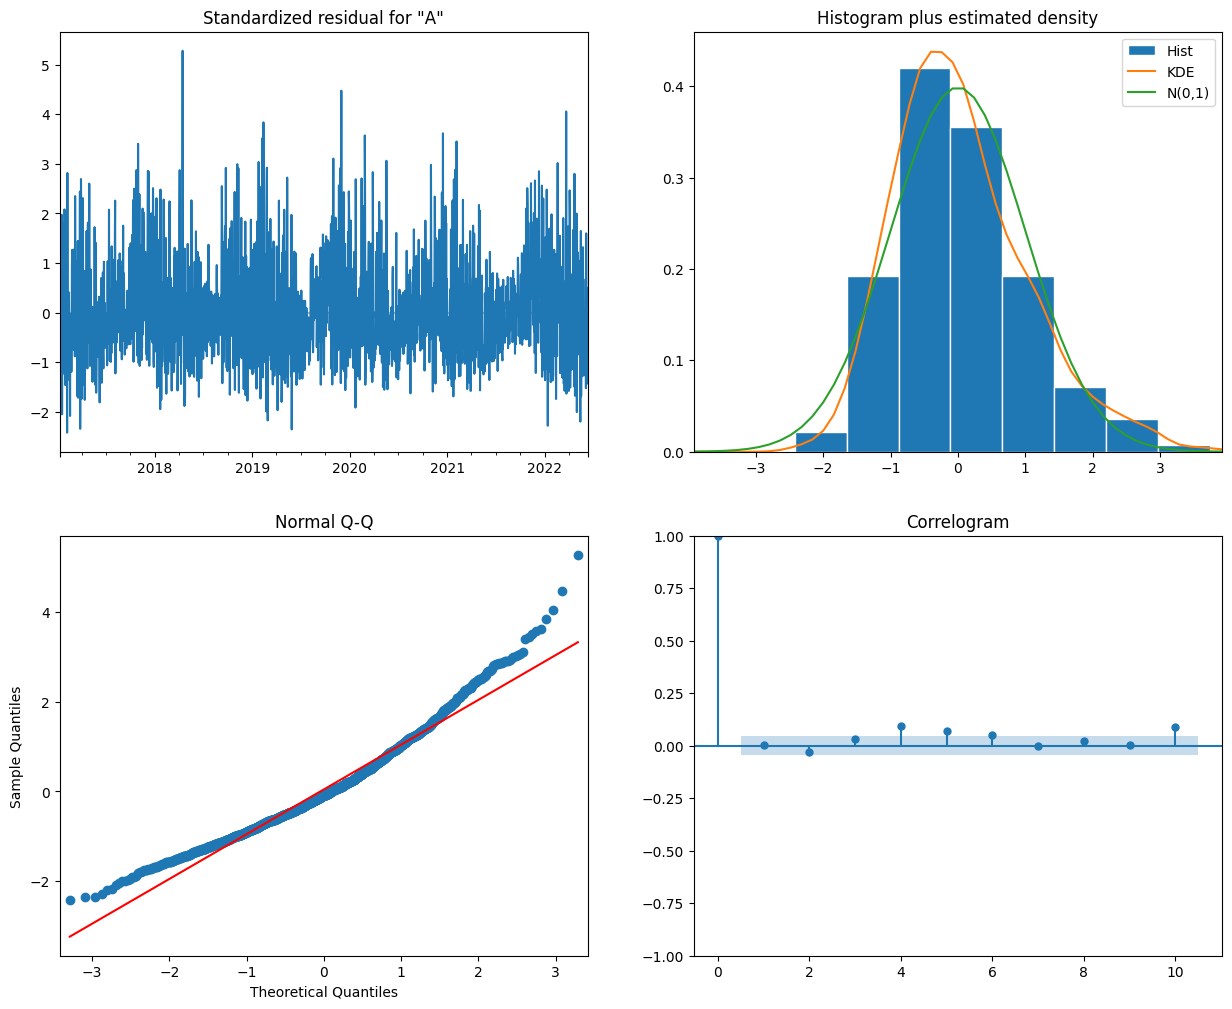

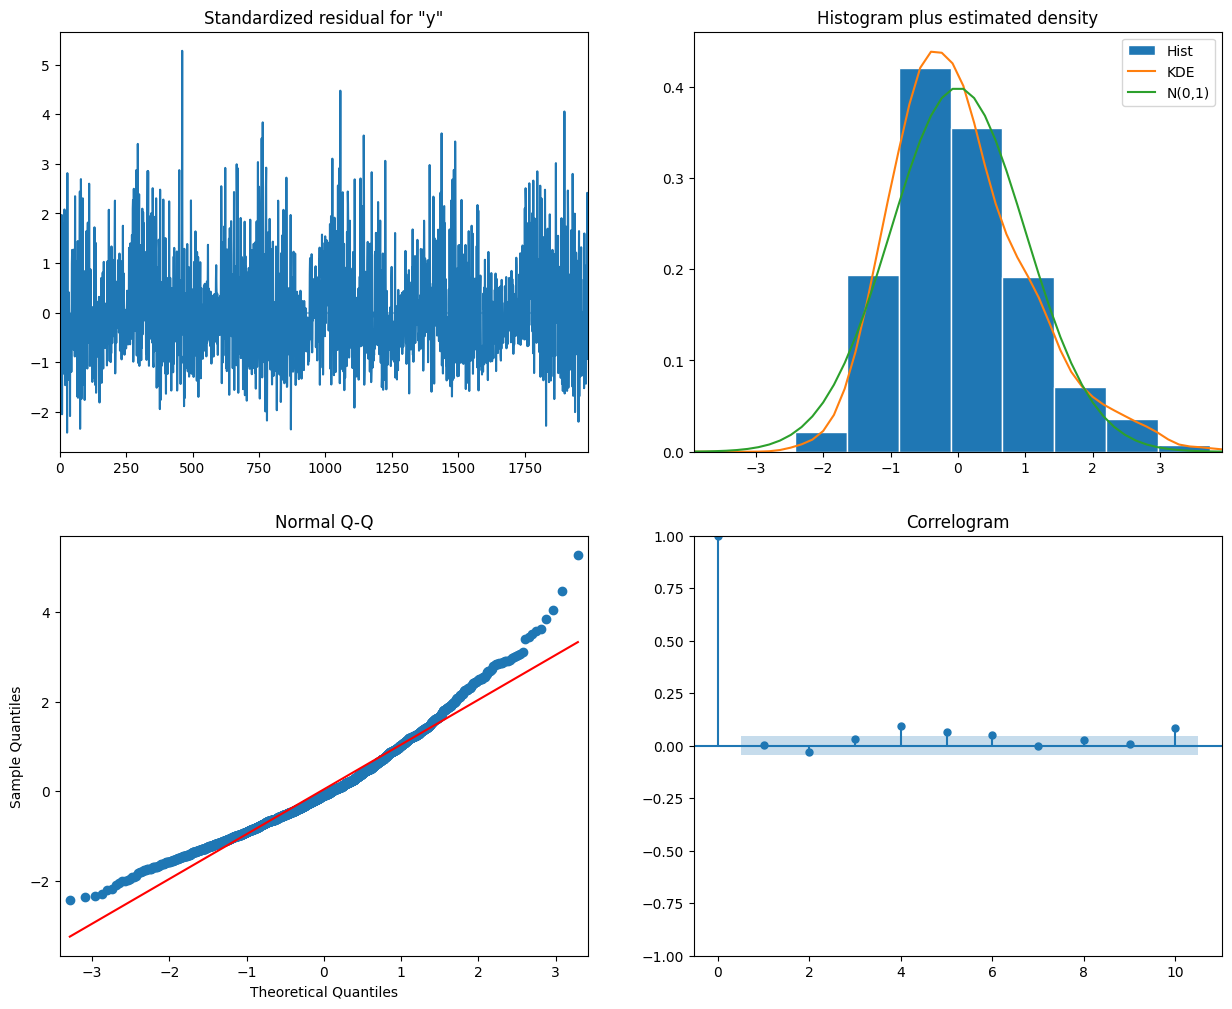

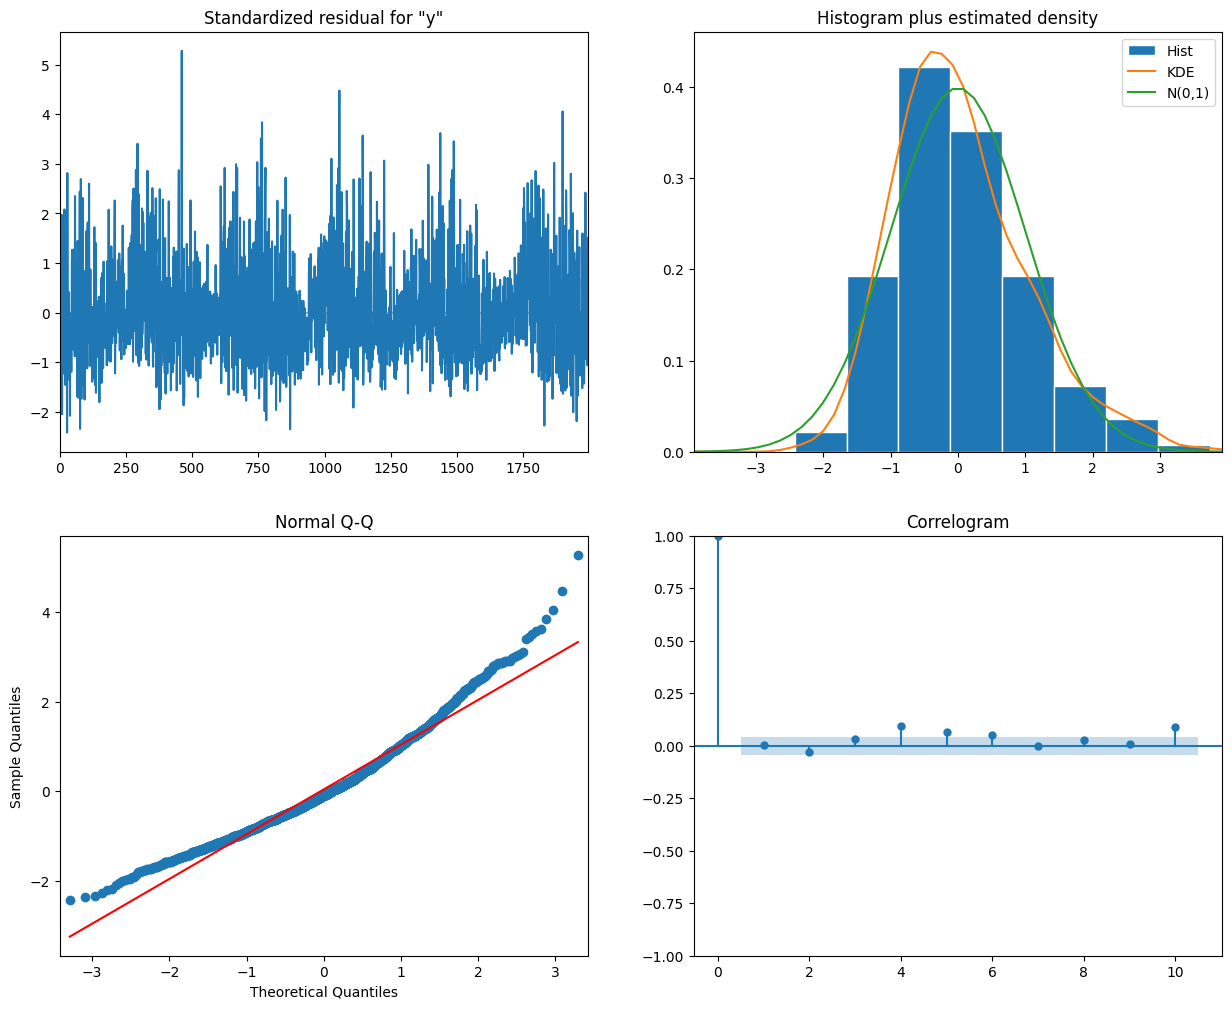

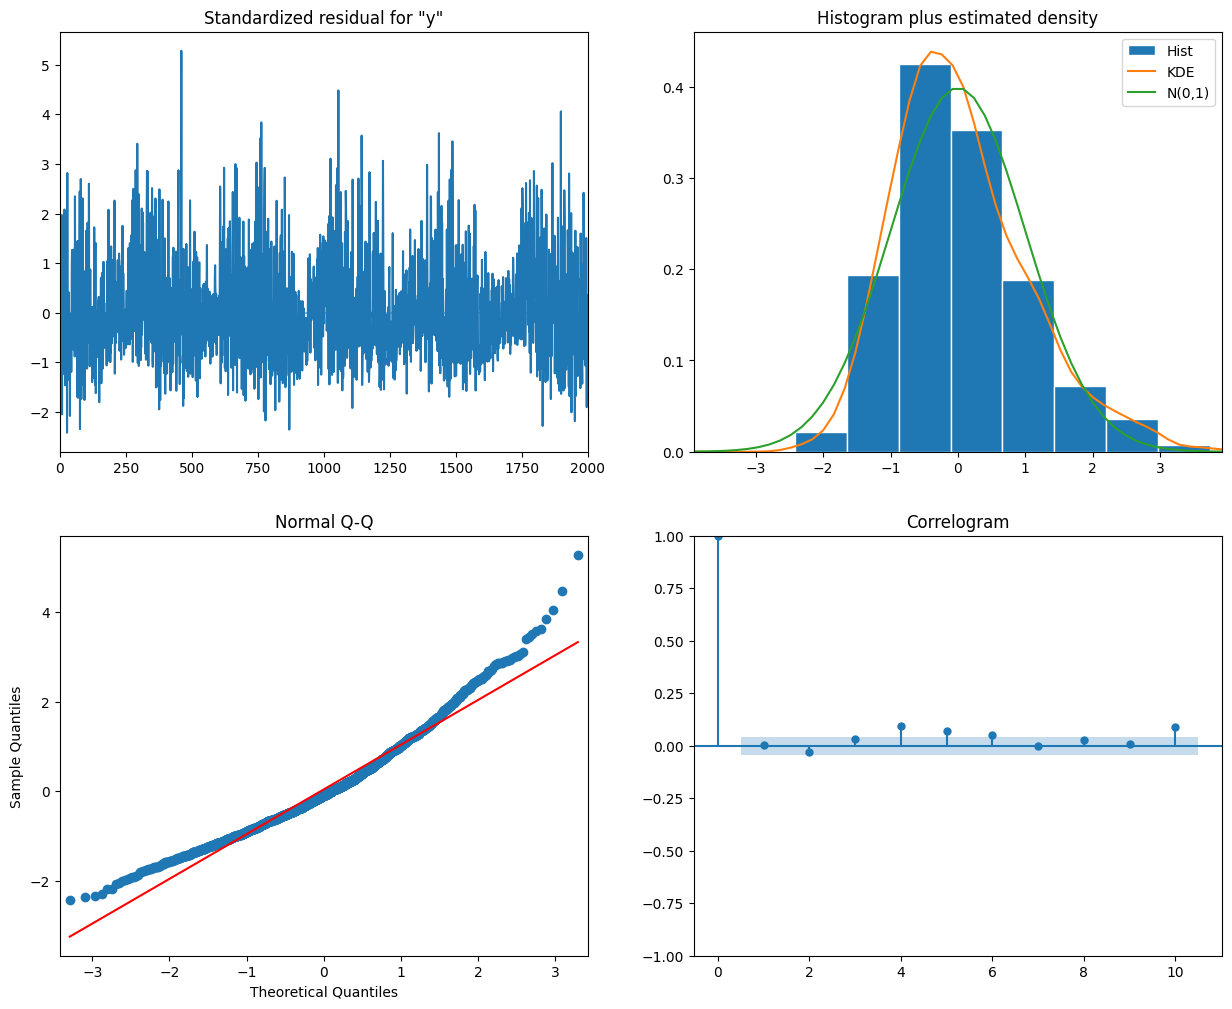

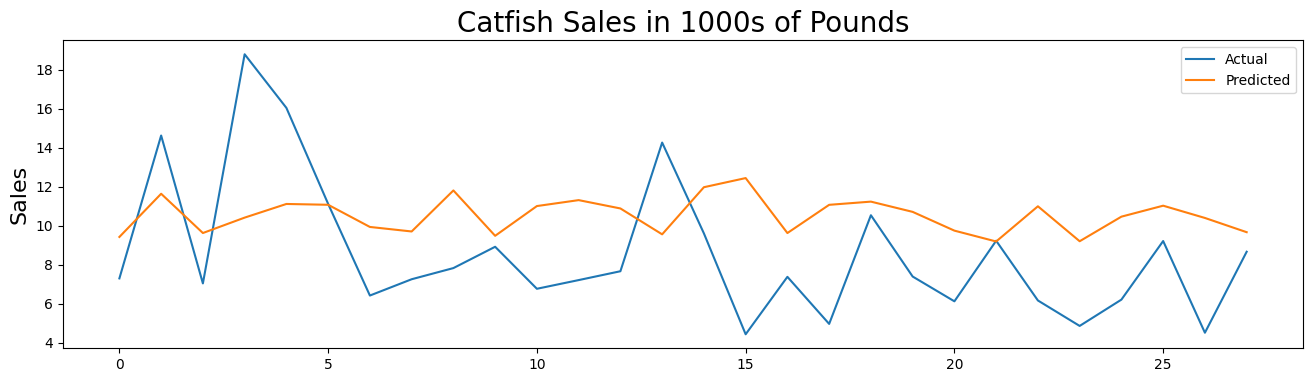

In [78]:
preds = Multivariate_wind_wf(wTor_season.AvgWind,1990,wTor_season.month)
pp = list(preds[0].predicted_mean)
pp.append(list(preds[1].predicted_mean))
pp.append(list(preds[2].predicted_mean))
pp.append(list(preds[3].predicted_mean))


plt.figure(figsize=(16,4))
plt.plot(wTor_season.AvgWind[1990:2018].values, label="Actual")
plt.plot(pd.Series(pp).explode().reset_index()[0].values, label="Predicted")
plt.title('Average Wind Forecast (with walk forward)', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [79]:
model_performance(wTor_season.AvgWind[1990:2018].values,pd.Series(pp).explode().reset_index()[0].values)


RMSE : 4.01
Normalized RMSE : 0.28


Multiveriate SarmiaX Forecasting Wind with Average Temperature as Exogenious feature (with Walk Forward)



Optimization terminated successfully.
         Current function value: 2.701267
         Iterations: 5
         Function evaluations: 357
Optimization terminated successfully.
         Current function value: 2.702857
         Iterations: 5
         Function evaluations: 354
Optimization terminated successfully.
         Current function value: 2.701726
         Iterations: 5
         Function evaluations: 357
Optimization terminated successfully.
         Current function value: 2.701311
         Iterations: 5
         Function evaluations: 357


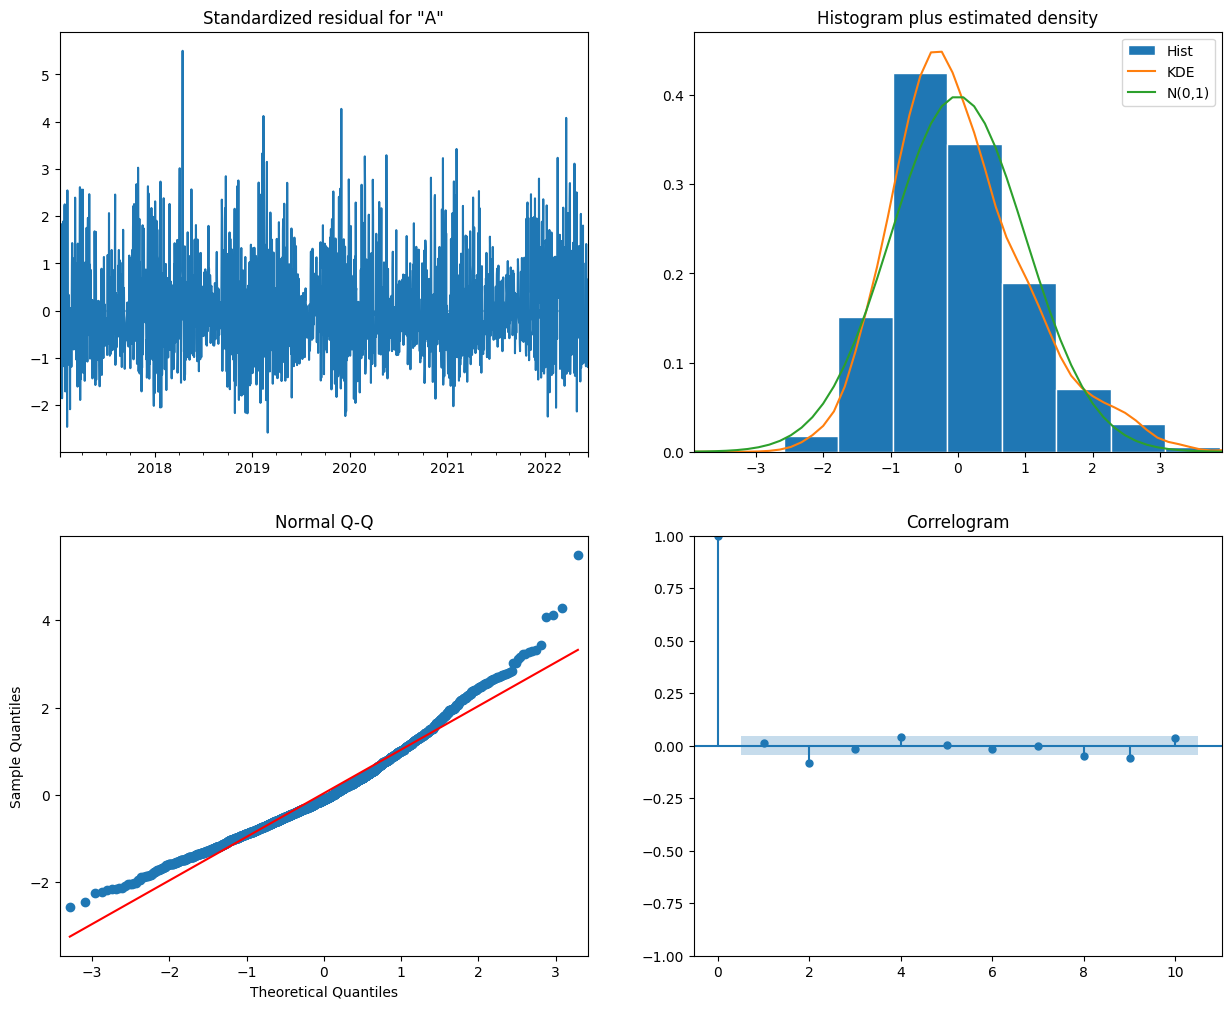

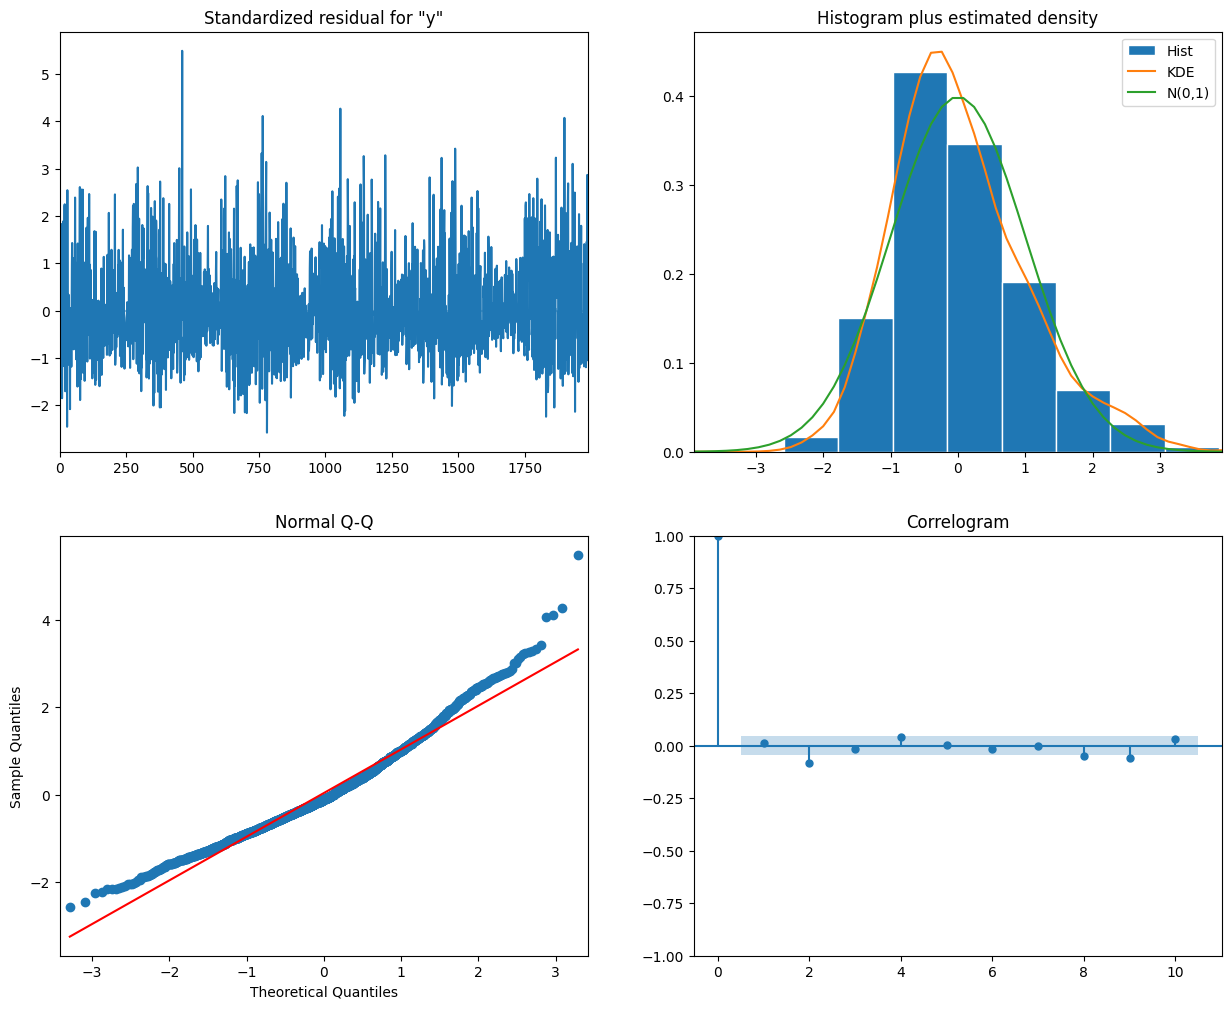

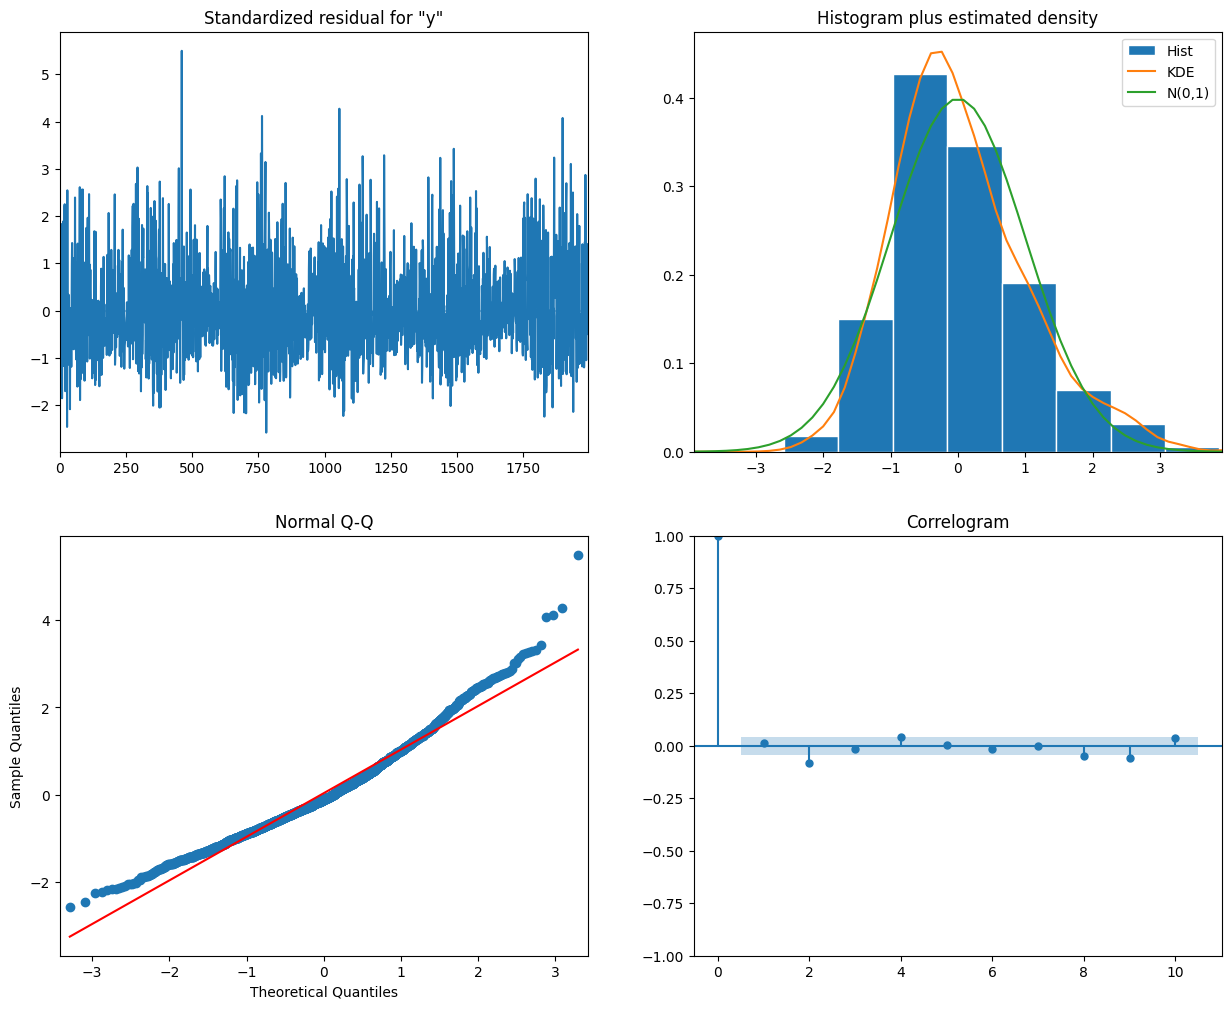

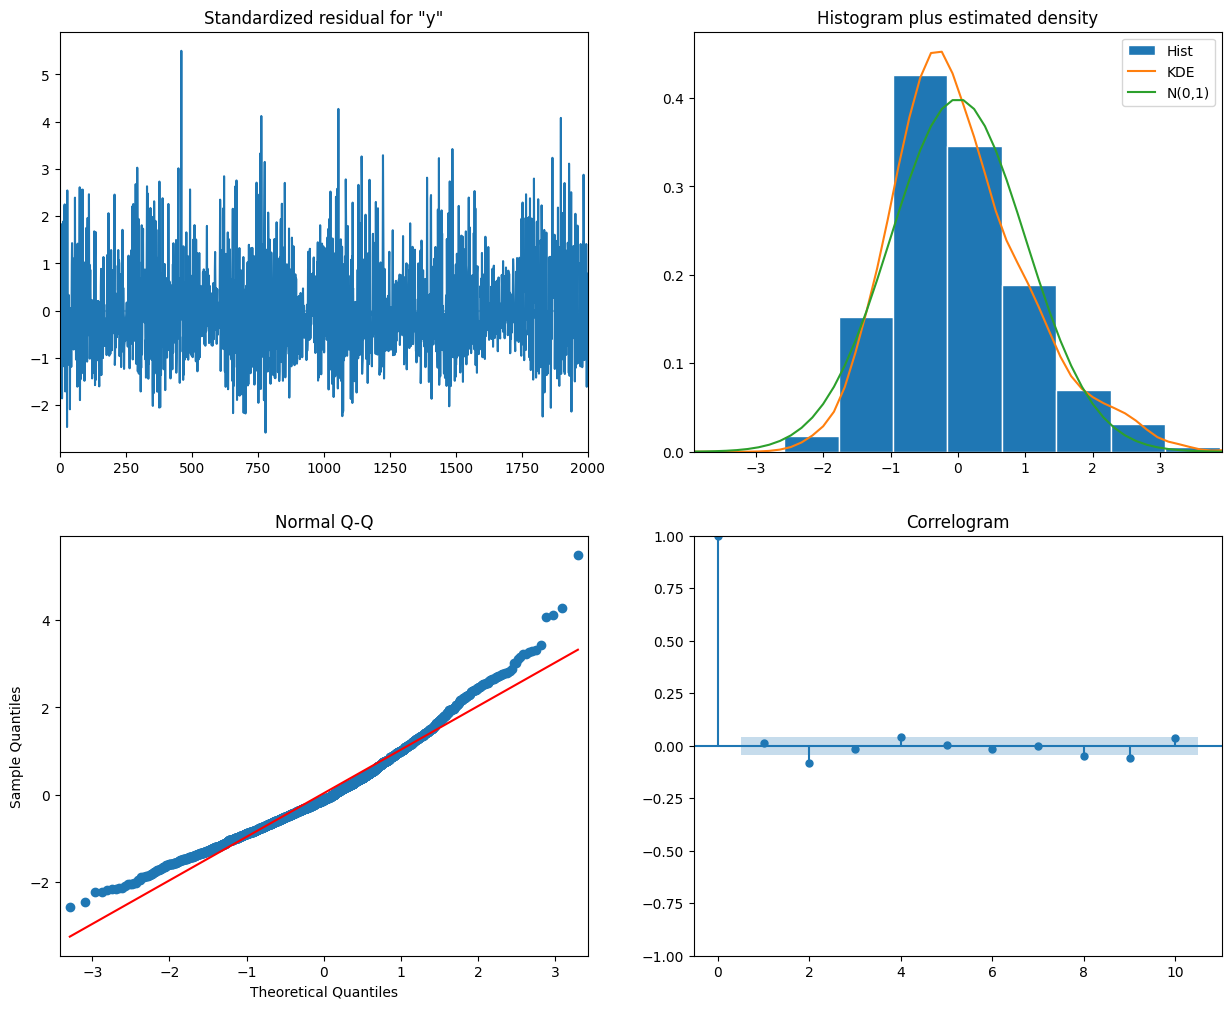

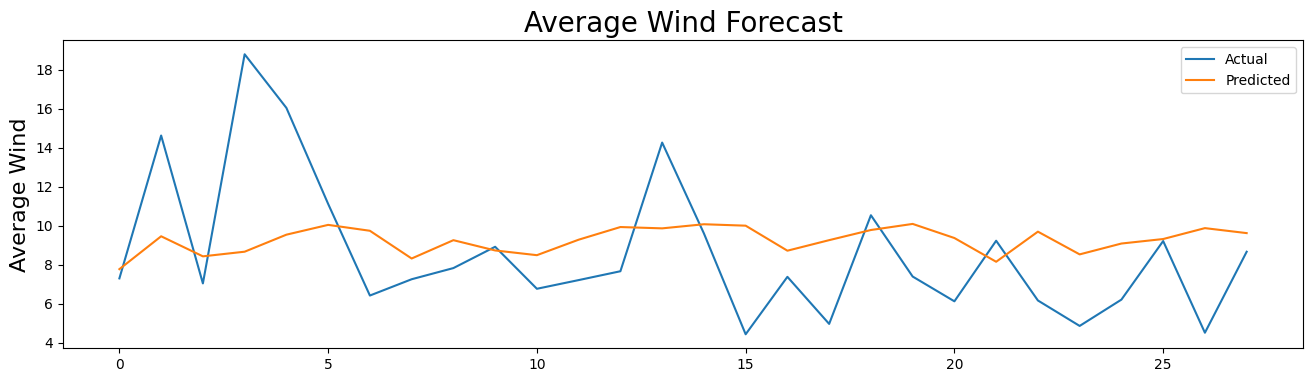

In [80]:
preds = Multivariate_wind_wf(wTor_season.AvgWind,1990,wTor_season.AvgT)
pp = list(preds[0].predicted_mean)
pp.append(list(preds[1].predicted_mean))
pp.append(list(preds[2].predicted_mean))
pp.append(list(preds[3].predicted_mean))


plt.figure(figsize=(16,4))
plt.plot(wTor_season.AvgWind[1990:2018].values, label="Actual")
plt.plot(pd.Series(pp).explode().reset_index()[0].values, label="Predicted")
plt.title('Average Wind Forecast', fontsize=20)
plt.ylabel('Average Wind', fontsize=16)
plt.legend()

In [81]:
model_performance(wTor_season.AvgWind[1990:2018].values,pd.Series(pp).explode().reset_index()[0].values)


RMSE : 3.56
Normalized RMSE : 0.25


#### Multivariate : Without walk forward method 

Multiveriate SarmiaX Forecasting Average Temperature with Month as Exogenious feature (without Walk Forward)



In [82]:
model = sm.tsa.statespace.SARIMAX(train.AvgT,exog=train.month, order=(0,1,0),
                                seasonal_order=(0,1,0,90), simple_differencing=False,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                ).fit(max_iter = 50,
                                          method = 'powell')
                                          #method='innovations_mle', low_memory=True)
        
        # Forecast daily loads for week i
forecast1 = model.get_forecast(steps = 30, dynamic=False, exog=test.month[:30])

Optimization terminated successfully.
         Current function value: 3.265688
         Iterations: 3
         Function evaluations: 101


<Axes: title={'center': 'Correlogram'}>

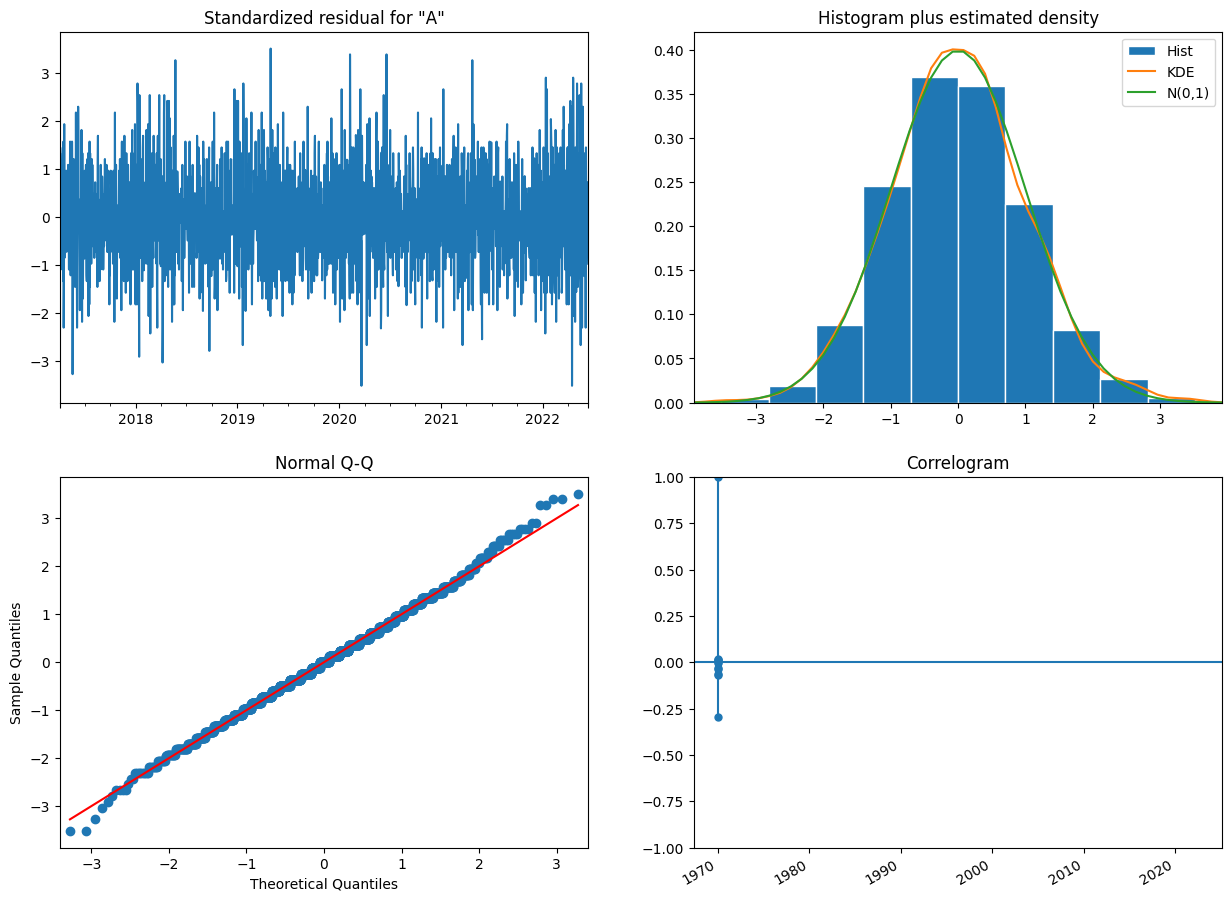

In [83]:
model.plot_diagnostics(figsize=(15, 12))
forecast1.predicted_mean.plot()

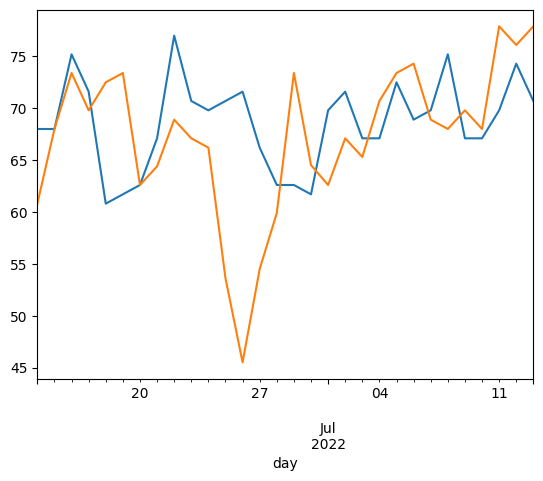


RMSE : 8.11
Normalized RMSE : 0.5
None


In [84]:
test.AvgT[:30].plot()
forecast1.predicted_mean.plot()
plt.show()
print(model_performance(test.AvgT[:30],forecast1.predicted_mean))

Multiveriate SarmiaX Forecasting Avg Temperature with Average Wind as Exogenious feature (without Walk Forward)



In [85]:
model = sm.tsa.statespace.SARIMAX(train.AvgT,exog=train.AvgWind, order=(0,1,0),
                                seasonal_order=(0,1,0,90), simple_differencing=False,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                ).fit(max_iter = 50,
                                          method = 'powell')
                                          #method='innovations_mle', low_memory=True)
        
        # Forecast daily loads for week i
forecast1 = model.get_forecast(steps = 30, dynamic=False, exog=test.AvgWind[:30])

Optimization terminated successfully.
         Current function value: 3.264116
         Iterations: 2
         Function evaluations: 75


<Axes: title={'center': 'Correlogram'}>

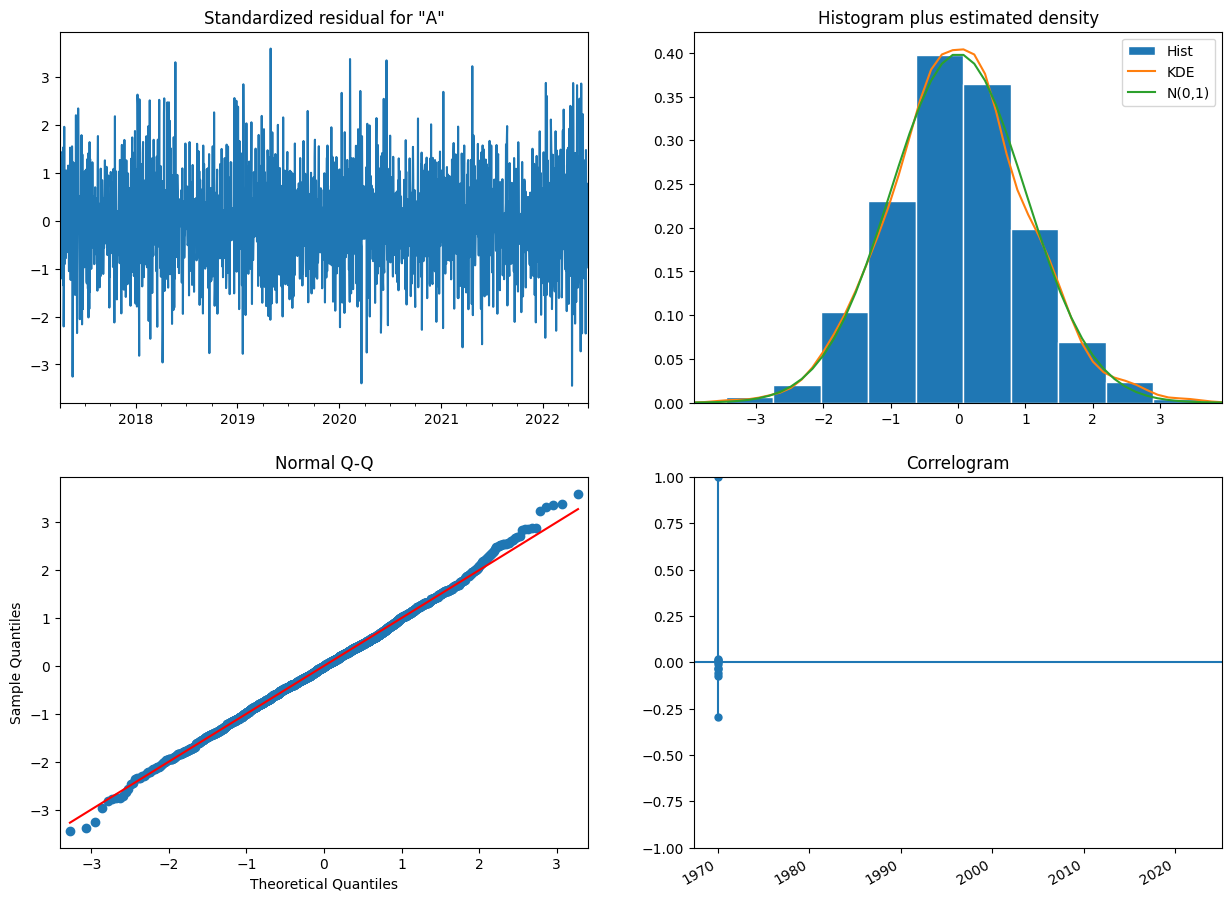

In [86]:
model.plot_diagnostics(figsize=(15, 12))
forecast1.predicted_mean.plot()

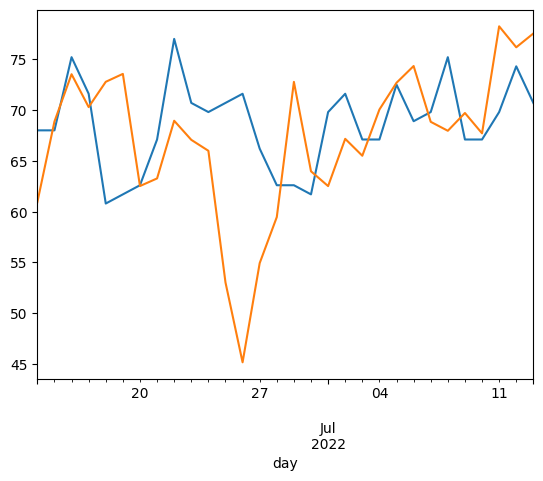


RMSE : 8.16
Normalized RMSE : 0.5
None


In [87]:
test.AvgT[:30].plot()
forecast1.predicted_mean.plot()
plt.show()
print(model_performance(test.AvgT[:30],forecast1.predicted_mean))

Multiveriate SarmiaX Forecasting Wind with Month as Exogenious feature (without Walk Forward)



In [88]:
model = sm.tsa.statespace.SARIMAX(train.AvgWind,exog=train.month, order=(1,1,1),
                                seasonal_order=(1,1,1,30), #simple_differencing=False,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                ).fit(max_iter = 50,
                                          method = 'powell')
                                          #method='innovations_mle', low_memory=True)
        
        # Forecast daily loads for week i
forecast1 = model.get_forecast(steps = 30, dynamic=False, exog=test.month[:30])

Optimization terminated successfully.
         Current function value: 2.656734
         Iterations: 4
         Function evaluations: 274


<Axes: title={'center': 'Correlogram'}>

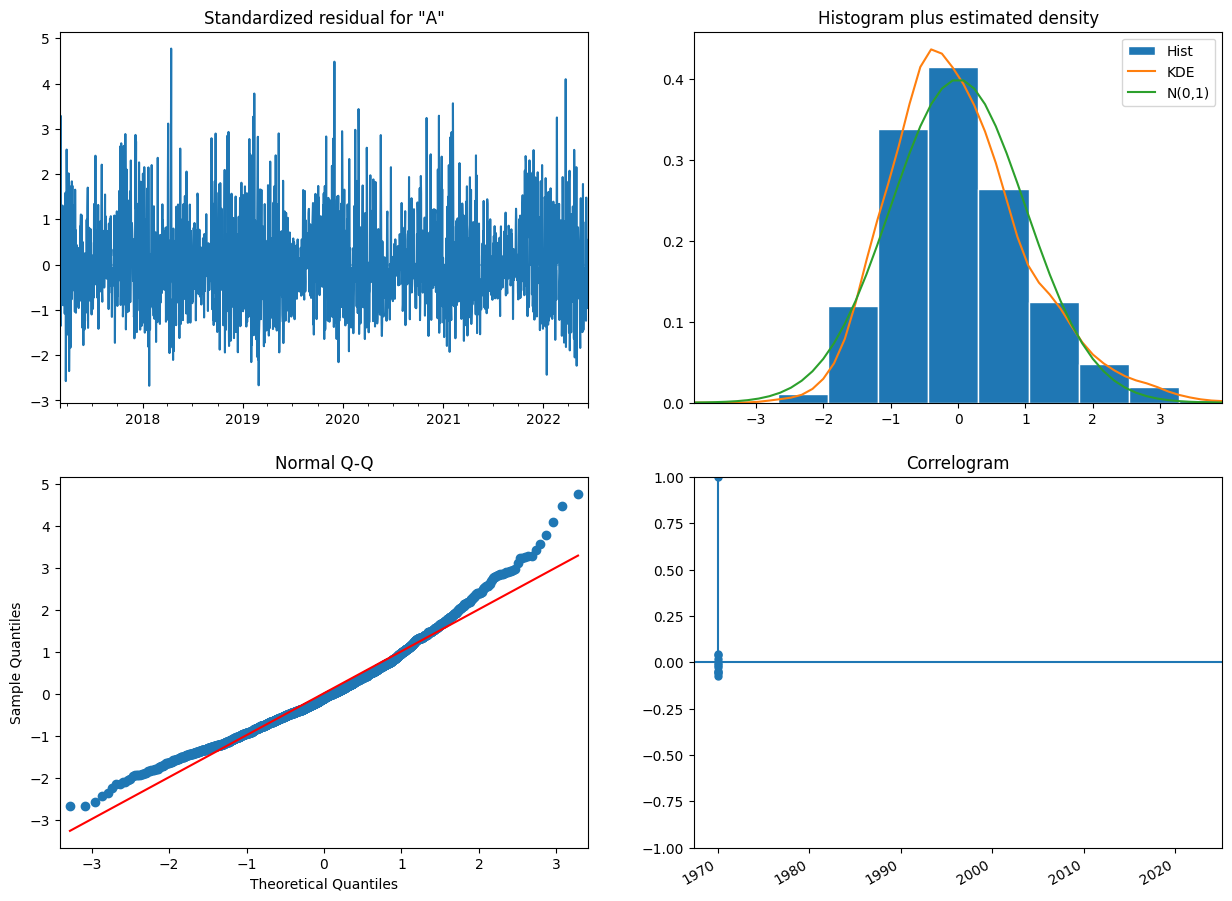

In [89]:
model.plot_diagnostics(figsize=(15, 12))
forecast1.predicted_mean.plot()

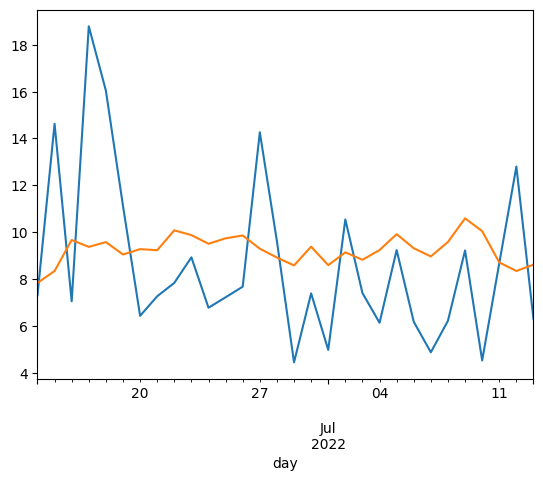


RMSE : 3.59
Normalized RMSE : 0.25
None


In [90]:
test.AvgWind[:30].plot()
forecast1.predicted_mean.plot()
plt.show()
print(model_performance(test.AvgWind[:30],forecast1.predicted_mean))

Multiveriate SarmiaX Forecasting Wind with Average Temp as Exogenious feature (without Walk Forward)



In [91]:
model = sm.tsa.statespace.SARIMAX(train.AvgWind,exog= train.AvgT, order=(1,1,1),
                                seasonal_order=(1,1,1,7), simple_differencing=False,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                ).fit(max_iter = 50,
                                          method = 'powell')
                                          #method='innovations_mle', low_memory=True)
        
        # Forecast daily loads for week i
forecast1 = model.get_forecast(steps = 30, dynamic=False, exog=test.AvgT[:30])

Optimization terminated successfully.
         Current function value: 2.687521
         Iterations: 5
         Function evaluations: 330


<Axes: title={'center': 'Correlogram'}>

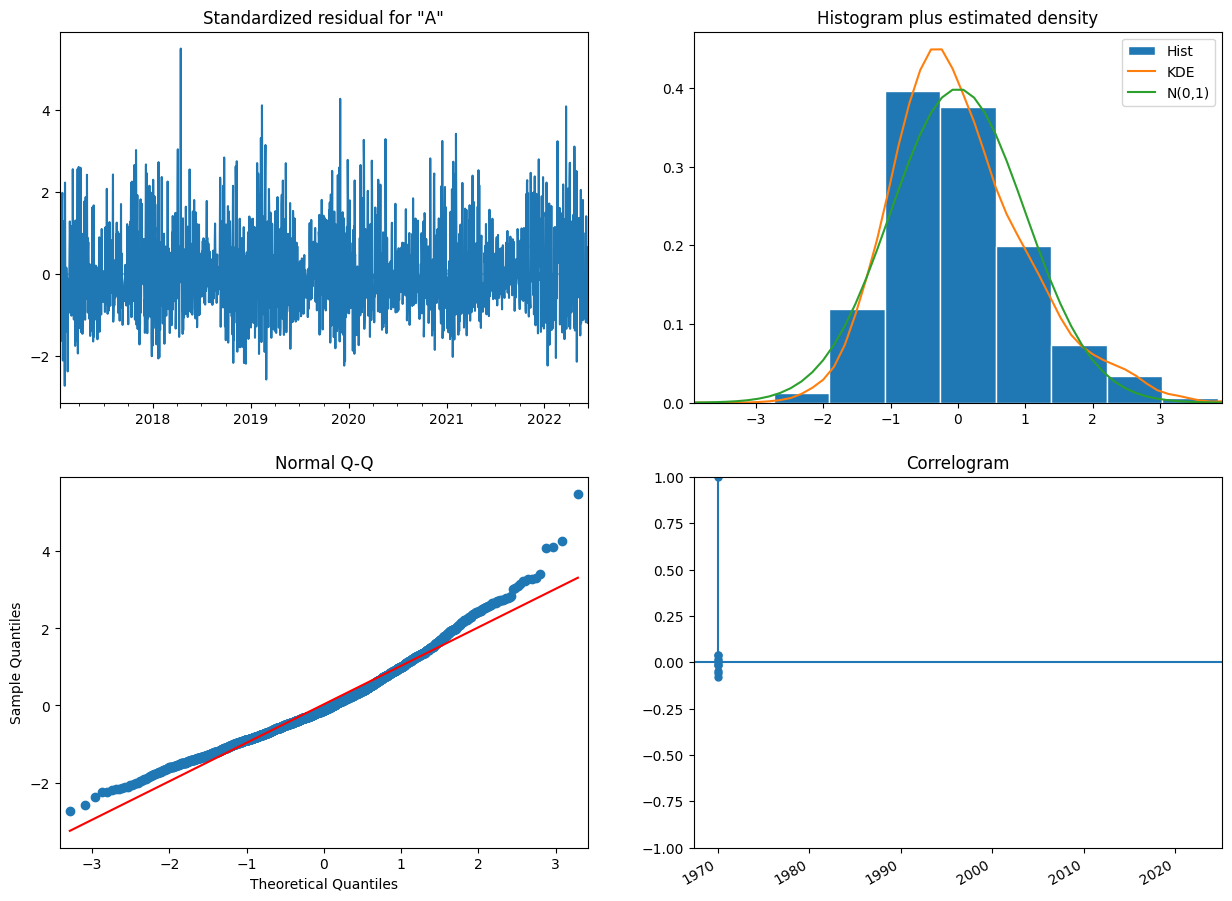

In [92]:
model.plot_diagnostics(figsize=(15, 12))
forecast1.predicted_mean.plot()

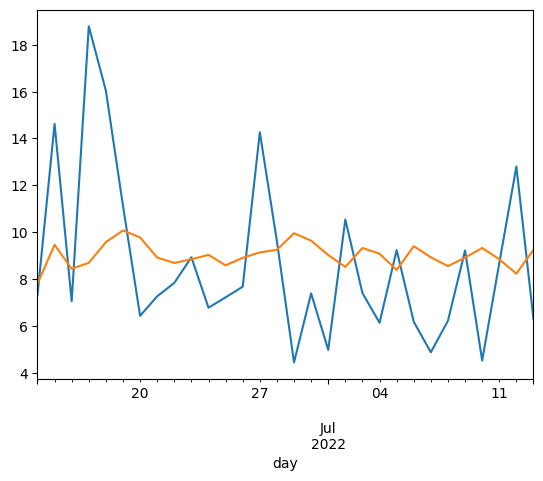


RMSE : 3.55
Normalized RMSE : 0.25
None


In [93]:
test.AvgWind[:30].plot()
forecast1.predicted_mean.plot()
plt.show()
print(model_performance(test.AvgWind[:30],forecast1.predicted_mean))

### Multivariate Model Fitting : Vector Auto Regression

In [94]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

<Axes: >

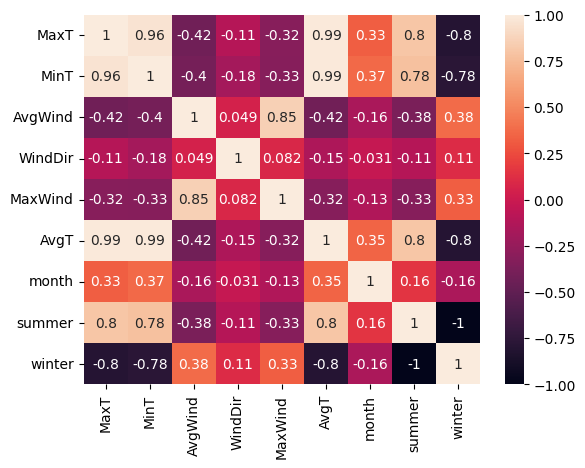

In [95]:
sns.heatmap(train.corr(),annot=True)

Checking correlation in variables for VAR model

In [96]:
from statsmodels.tsa.stattools import grangercausalitytests


In [97]:
maxlag = 10
#test_name   = 'ssr_chi2test'

In [98]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#Ref : https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/

In [99]:
grangers_causation_matrix(wTor_season, variables = wTor_season.columns)

MaxT_x  MinT_x  AvgWind_x  WindDir_x  MaxWind_x  AvgT_x  month_x  \
MaxT_y     1.0000  0.0000     0.0000     0.0000     0.0000  0.0000   0.0123   
MinT_y     0.0000  1.0000     0.0000     0.0000     0.0000  0.0000   0.0124   
AvgWind_y  0.0000  0.0000     1.0000     0.0018     0.0000  0.0000   0.0001   
WindDir_y  0.0000  0.0000     0.0000     1.0000     0.0000  0.0000   0.2856   
MaxWind_y  0.0000  0.0000     0.0026     0.0000     1.0000  0.0000   0.0014   
AvgT_y     0.0000  0.0000     0.0000     0.0000     0.0000  1.0000   0.0161   
month_y    0.0000  0.0000     0.0002     0.0714     0.0028  0.0000   1.0000   
summer_y   0.0005  0.0017     0.5924     0.0372     0.5651  0.0006   0.0380   
winter_y   0.0005  0.0017     0.5924     0.0372     0.5651  0.0006   0.0380   

           summer_x  winter_x  
MaxT_y       0.0000    0.0000  
MinT_y       0.0000    0.0000  
AvgWind_y    0.0000    0.0000  
WindDir_y    0.0003    0.0003  
MaxWind_y    0.0000    0.0000  
AvgT_y       0.0000    0.0000  
month_y      0.0067    0.0067  
summer_y     1.0000    1.0000  
winter_y     1.0000    1.0000

<Axes: >

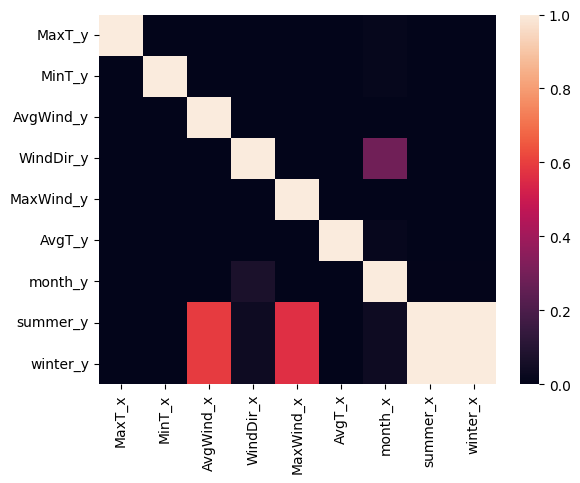

In [100]:
sns.heatmap(grangers_causation_matrix(wTor_season, variables = wTor_season.columns),)

In [101]:
adfVal = adfuller(wTor_season['AvgWind'], autolag = 'AIC')
print("1. ADF : ",adfVal[0])
print("2. P-Value : ", adfVal[1])
print("3. Num Of Lags : ", adfVal[2])
print("4. Num Of Observations", adfVal[3])
print("5. Critical Values :")
for key, val in adfVal[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.8860715870330726
2. P-Value :  0.0021397776318647873
3. Num Of Lags :  25
4. Num Of Observations 2186
5. Critical Values :
	 1% :  -3.433344965914077
	 5% :  -2.8628630765096195
	 10% :  -2.567474338973205


In [102]:
adfVal = adfuller(wTor_season['WindDir'], autolag = 'AIC')
print("1. ADF : ",adfVal[0])
print("2. P-Value : ", adfVal[1])
print("3. Num Of Lags : ", adfVal[2])
print("4. Num Of Observations", adfVal[3])
print("5. Critical Values :")
for key, val in adfVal[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.196902850352088
2. P-Value :  2.4213653692625174e-10
3. Num Of Lags :  25
4. Num Of Observations 2186
5. Critical Values :
	 1% :  -3.433344965914077
	 5% :  -2.8628630765096195
	 10% :  -2.567474338973205


In [103]:
adfVal = adfuller(wTor_season['month'], autolag = 'AIC')
print("1. ADF : ",adfVal[0])
print("2. P-Value : ", adfVal[1])
print("3. Num Of Lags : ", adfVal[2])
print("4. Num Of Observations", adfVal[3])
print("5. Critical Values :")
for key, val in adfVal[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.065605517183782
2. P-Value :  0.001103376080207832
3. Num Of Lags :  0
4. Num Of Observations 2211
5. Critical Values :
	 1% :  -3.433311062093479
	 5% :  -2.8628481063596647
	 10% :  -2.5674663683699017


In [104]:
forecasting_model = VAR(train[["AvgT","AvgWind","month","summer"]])
results_aic = []
for p in range(1,20):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

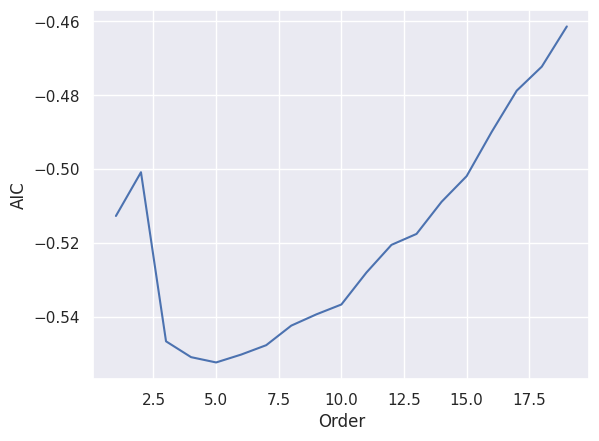

In [105]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,20,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [106]:
results = forecasting_model.fit(3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Apr, 2023
Time:                     05:45:39
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.400311
Nobs:                     1987.00    HQIC:                 -0.492942
Log likelihood:          -10682.6    FPE:                   0.578848
AIC:                    -0.546717    Det(Omega_mle):        0.563944
--------------------------------------------------------------------
Results for equation AvgT
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              7.608364         0.774336            9.826           0.000
L1.AvgT            0.845558         0.022004           38.428           0.000
L1.AvgWind        -0.292889         0.030697           -9.541           0

In [107]:
prediction = results.forecast(y=train[["AvgT","AvgWind","month","summer"]].values[-3:], steps=30)


In [108]:
resultsDF= pd.DataFrame(data=prediction, columns=[["AvgT","AvgWind","month","summer"]]) #Storing predictions in dataframe

In [109]:
resultsDF.set_index(test[:30].index,inplace=True)

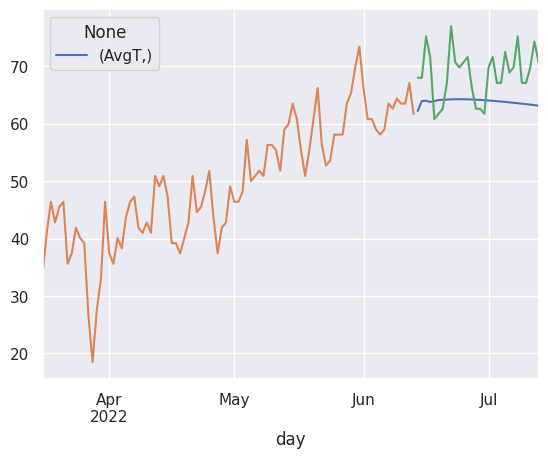

In [110]:
resultsDF["AvgT"].plot()
train.AvgT[1900:].plot()

test.AvgT[:30].plot()
plt.show()

In [111]:
model_performance(test.AvgT[:30].values,resultsDF["AvgT"].values)


RMSE : 6.39
Normalized RMSE : 0.39


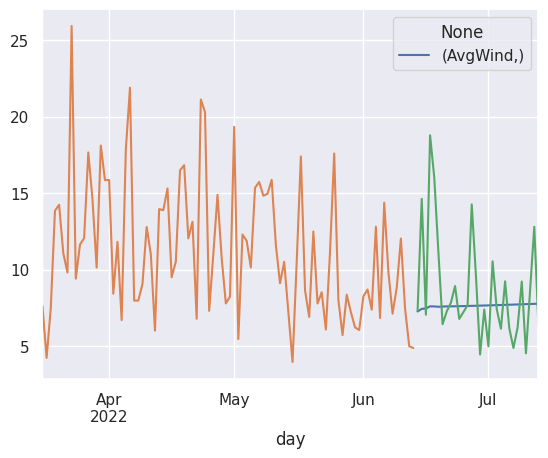

In [112]:
resultsDF["AvgWind"].plot()
train.AvgWind[1900:].plot()
test.AvgWind[:30].plot()
plt.show()

In [113]:
model_performance(test.AvgWind[:30].values,resultsDF["AvgWind"].values)


RMSE : 3.62
Normalized RMSE : 0.25


### Spatio Temporal Approach 




### Spatial and Temporal data pre-processing

Importing ontario province data with multiple spatial stations

In [114]:
df0 = pd.read_excel("/content/Ontario daily.xlsx")

In [115]:
df0.head()

station        day max_temp_f min_temp_f avg_wind_speed_kts avg_wind_drct  \
0    CWQP 2017-01-01         39         27          12.652174      268.6966   
1    CWBE 2017-01-01       35.2       16.2            7.73913     258.47382   
2    CWMZ 2017-01-01       36.3       29.7          22.086956     259.42496   
3    CYTZ 2017-01-01       37.4         32          11.956522     245.61368   
4    CWPS 2017-01-01       36.7       30.2           8.782609     219.92087   

  max_wind_gust_kts  
0                41  
1                25  
2                42  
3                28  
4                30

In [116]:
df2 = df0.copy()

Creating a list of station names

In [117]:
stationsUsed = ["CXTO", "CYTZ", "CYYZ", "CYKZ", "CYOO", "CYKF", "CXHM","CWWB", "CYHM", "CXVN","CWWZ", "CYSN", "CZEL"]

In [118]:
df2 = df2[df0.station.isin(stationsUsed)]


In [119]:
df2.head()

station        day max_temp_f min_temp_f avg_wind_speed_kts avg_wind_drct  \
3     CYTZ 2017-01-01       37.4         32          11.956522     245.61368   
11    CWWB 2017-01-01       37.9       31.5           5.826087     230.53685   
13    CYHM 2017-01-01       35.6       24.8           8.652174     240.98889   
21    CWWZ 2017-01-01       40.5       30.9           7.043478     249.58049   
29    CYSN 2017-01-01       39.2       28.4           9.142858     228.71013   

   max_wind_gust_kts  
3                 28  
11                21  
13                21  
21                35  
29                17

Checking for Null values

In [120]:
def checkforNulls(df):
  for i in df.columns:
    print("\nColumn name : {}".format(i))
    count = 0
    for j in df[i]:
      if j == "None":
        count = count+1
    print("Null count : ",count)

In [121]:
checkforNulls(df2)


Column name : station
Null count :  0

Column name : day
Null count :  0

Column name : max_temp_f
Null count :  1914

Column name : min_temp_f
Null count :  1914

Column name : avg_wind_speed_kts
Null count :  1620

Column name : avg_wind_drct
Null count :  1620

Column name : max_wind_gust_kts
Null count :  10780


In [122]:
df2.drop(['max_wind_gust_kts'],axis=1, inplace=True)

In [123]:
checkforNulls(df2)


Column name : station
Null count :  0

Column name : day
Null count :  0

Column name : max_temp_f
Null count :  1914

Column name : min_temp_f
Null count :  1914

Column name : avg_wind_speed_kts
Null count :  1620

Column name : avg_wind_drct
Null count :  1620


In [124]:
df2 = df2.replace('None', np.nan)

Using Forward fill for null values

In [125]:
df2.ffill(inplace=True)

In [126]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28496 entries, 3 to 197264
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   station             28496 non-null  object        
 1   day                 28496 non-null  datetime64[ns]
 2   max_temp_f          28496 non-null  float64       
 3   min_temp_f          28496 non-null  float64       
 4   avg_wind_speed_kts  28496 non-null  float64       
 5   avg_wind_drct       28496 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.5+ MB


In [127]:
df2.columns = ["station","day","MaxT","MinT","AvgWind","WindDir"]

In [128]:
df2.head()

station        day  MaxT  MinT    AvgWind    WindDir
3     CYTZ 2017-01-01  37.4  32.0  11.956522  245.61368
11    CWWB 2017-01-01  37.9  31.5   5.826087  230.53685
13    CYHM 2017-01-01  35.6  24.8   8.652174  240.98889
21    CWWZ 2017-01-01  40.5  30.9   7.043478  249.58049
29    CYSN 2017-01-01  39.2  28.4   9.142858  228.71013

Adding Average temperature column

In [129]:
def avg_temp(day):
    return (day.MaxT+day.MinT)/2
df2['AvgT'] = df2.apply(avg_temp,axis=1)


In [130]:
df2.head()

station        day  MaxT  MinT    AvgWind    WindDir  AvgT
3     CYTZ 2017-01-01  37.4  32.0  11.956522  245.61368  34.7
11    CWWB 2017-01-01  37.9  31.5   5.826087  230.53685  34.7
13    CYHM 2017-01-01  35.6  24.8   8.652174  240.98889  30.2
21    CWWZ 2017-01-01  40.5  30.9   7.043478  249.58049  35.7
29    CYSN 2017-01-01  39.2  28.4   9.142858  228.71013  33.8

In [131]:
df_avgT = df2.groupby('day').agg({'AvgT':list})

In [132]:
df_avgT.head()

AvgT
day                                                          
2017-01-01  [34.7, 34.7, 30.200000000000003, 35.7, 33.8, 2...
2017-01-02  [27.5, 32.9, 30.2, 30.200000000000003, 33.8, 3...
2017-01-03  [34.55, 37.400000000000006, 40.1, 39.0, 37.400...
2017-01-04  [28.299999999999997, 29.3, 28.4, 29.2, 29.3, 2...
2017-01-05  [10.3, 18.5, 17.700000000000003, 17.8, 19.4, 1...

In [133]:
df_avgT_F = pd.DataFrame(df_avgT['AvgT'].tolist(),index=df_avgT.index).add_prefix("s")

In [134]:
df_avgT_F.head()

s0    s1    s2    s3    s4     s5     s6     s7     s8     s9  \
day                                                                            
2017-01-01  34.70  34.7  30.2  35.7  33.8  28.40  21.55  33.35  33.80  34.25   
2017-01-02  27.50  32.9  30.2  30.2  33.8  32.00  35.55  36.50  35.25  33.65   
2017-01-03  34.55  37.4  40.1  39.0  37.4  35.60  35.60  36.50  41.00  37.85   
2017-01-04  28.30  29.3  28.4  29.2  29.3  26.60  23.55  28.40  24.80  25.70   
2017-01-05  10.30  18.5  17.7  17.8  19.4  19.15  14.90  18.50  17.60  15.80   

              s10   s11    s12  
day                             
2017-01-01  32.00  31.1  22.10  
2017-01-02  37.15  32.9  26.95  
2017-01-03  39.05  38.5  38.75  
2017-01-04  29.90  28.4  26.60  
2017-01-05  13.10  15.8  21.40

In [135]:
df_AvgWind = df2.groupby('day').agg({'AvgWind':list})
df_AvgWind_F = pd.DataFrame(df_AvgWind['AvgWind'].tolist(),index=df_AvgWind.index).add_prefix("s")

In [136]:
df_AvgWind_F.head()

s0         s1        s2         s3         s4         s5  \
day                                                                           
2017-01-01  11.956522   5.826087  8.652174   7.043478   9.142858   7.152899   
2017-01-02   7.354210   7.119318  6.972464   9.639131   5.761905   8.960145   
2017-01-03   5.956522   6.471014  8.441240   6.521739   6.823188   5.476720   
2017-01-04   9.869565  15.086957  0.000000  12.043478  20.355797  19.548552   
2017-01-05  14.608696   0.000000  7.478261  11.869565  18.696377   9.695652   

                   s6         s7         s8         s9        s10        s11  \
day                                                                            
2017-01-01   6.652174   4.173913   7.521739   0.000000   9.434783   6.215942   
2017-01-02   8.826087  11.342960   7.260870   3.869565   0.000000   2.521739   
2017-01-03   6.645025   8.400993   4.891270   6.565218   3.217391   0.000000   
2017-01-04  18.956522  19.197826  20.135078  11.676087  17.869566  16.746826   
2017-01-05  13.296377  11.369842  12.605797  11.336232  14.329710  14.718841   

                  s12  
day                    
2017-01-01   7.656450  
2017-01-02   8.652174  
2017-01-03   2.869565  
2017-01-04  13.411594  
2017-01-05  14.782609

In [137]:
df_avgT_F.to_csv('df_avgT_F', index=False, header=False)

In [138]:
df_AvgWind_F.to_csv('df_AvgWind_F', index=False, header=False)

### Spatio Temporal Model Building


Here we will use spatial data of 13 stations and forecast on the station no. 1.

In [139]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
data = pd.read_csv('/content/df_avgT_F', header=None)

In [140]:
data.shape

(2192, 13)

Creating model for forecasting temperature using spatial and temporal data


In [141]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Loading the data
data = pd.read_csv("/content/df_avgT_F", header=None)

# Setting the first column as the target variable
y = data.iloc[:, 0].values

# Set the remaining columns as the input features
X = data.iloc[:, 1:].values

# Spliting the data into training and testing sets, data has over 2000 rows and we want to forecast for next 30 days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02 , shuffle=False) 

# Normalizing the input features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshaping the data to be 3-dimensional for input into the LSTM layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the model architecture
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the model, using 50 epochs to train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test)
print("Mean squared error on test set:", mse)


Epoch 1/50
54/54 [==============================] - 8s 20ms/step - loss: 1879.8627 - val_loss: 1274.8625
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 1069.4657 - val_loss: 894.7989
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 775.6580 - val_loss: 659.4827
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 591.2448 - val_loss: 510.2649
Epoch 5/50
54/54 [==============================] - 0s 5ms/step - loss: 480.8998 - val_loss: 423.7098
Epoch 6/50
54/54 [==============================] - 0s 5ms/step - loss: 413.6322 - val_loss: 373.1080
Epoch 7/50
54/54 [==============================] - 0s 6ms/step - loss: 381.5760 - val_loss: 345.8346
Epoch 8/50
54/54 [==============================] - 0s 5ms/step - loss: 359.6994 - val_loss: 331.4642
Epoch 9/50
54/54 [==============================] - 0s 5ms/step - loss: 351.0652 - val_loss: 325.1908
Epoch 10/50
54/54 [==============================] - 0s 5ms/step - loss: 350.5

In [142]:
y_pred = model.predict(X_test)


2/2 [==============================] - 1s 6ms/step


Evaluating the model performance 

In [145]:
print(model_performance(y_test, y_pred))


RMSE : 10.97
Normalized RMSE : 0.25
None


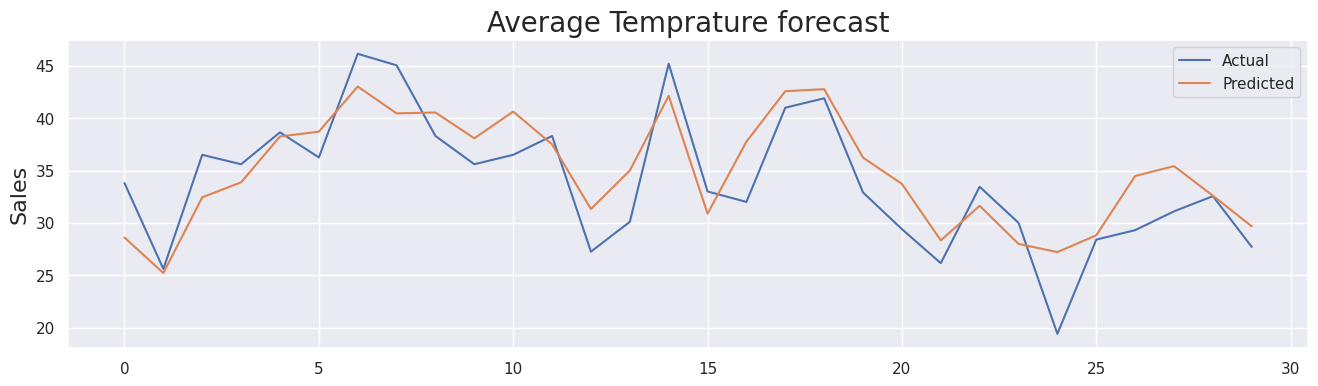

In [146]:
plt.figure(figsize=(16,4))
plt.plot(y_test[:30], label="Actual")

plt.plot(y_pred[:30], label="Predicted")
plt.title('Average Temprature forecast', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

Creating model for forecasting Wind using spatial and temporal data


In [147]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Loading the data
data = pd.read_csv("/content/df_AvgWind_F", header=None)

# Setting the first column as the target variable
y = data.iloc[:, 0].values

# Set the remaining columns as the input features
X = data.iloc[:, 1:].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=False)

# Normalizing the input features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data to be 3-dimensional for input into the LSTM layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Defining the model architecture
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test)
print("Mean squared error on test set:", mse)


Epoch 1/50
54/54 [==============================] - 3s 12ms/step - loss: 32.4991 - val_loss: 15.7069
Epoch 2/50
54/54 [==============================] - 0s 5ms/step - loss: 13.0806 - val_loss: 13.6851
Epoch 3/50
54/54 [==============================] - 0s 5ms/step - loss: 11.6468 - val_loss: 11.8677
Epoch 4/50
54/54 [==============================] - 0s 6ms/step - loss: 11.7842 - val_loss: 11.6668
Epoch 5/50
54/54 [==============================] - 0s 5ms/step - loss: 11.8850 - val_loss: 12.7420
Epoch 6/50
54/54 [==============================] - 0s 5ms/step - loss: 11.4676 - val_loss: 11.4959
Epoch 7/50
54/54 [==============================] - 0s 6ms/step - loss: 11.5510 - val_loss: 12.9562
Epoch 8/50
54/54 [==============================] - 0s 5ms/step - loss: 11.5710 - val_loss: 11.4652
Epoch 9/50
54/54 [==============================] - 0s 6ms/step - loss: 11.8429 - val_loss: 11.6388
Epoch 10/50
54/54 [==============================] - 0s 6ms/step - loss: 12.1681 - val_loss: 11.385

In [148]:
y_pred = model.predict(X_test)


2/2 [==============================] - 0s 6ms/step


In [150]:
print(model_performance(y_test, y_pred))


RMSE : 5.98
Normalized RMSE : 0.26
None


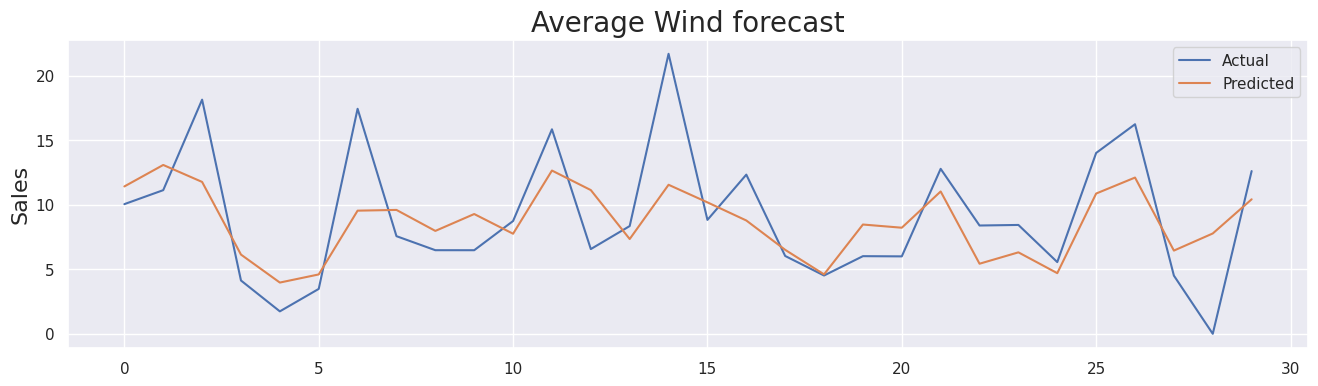

In [151]:
plt.figure(figsize=(16,4))
plt.plot(y_test[:30], label="Actual")

plt.plot(y_pred[:30], label="Predicted")
plt.title('Average Wind forecast', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()
